<a href="https://colab.research.google.com/github/SzymonNowakowski/Machine-Learning-2024/blob/master/Lab13-towards-self-attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 13 - Towards Self-Attention (*pl. Samoatencja*)


### Author: Szymon Nowakowski


# Introduction
---------------

In this class, we build on our understanding of attention by introducing **self-attention**—a powerful mechanism that allows each word in a sentence to attend to **every other word**, including itself. While basic attention required an external query (e.g., from a classifier or decoder), self-attention uses the words within a sequence to compute their mutual influence, enabling the model to capture dependencies regardless of distance or position.

This mechanism lies at the heart of modern architectures like the Transformer. By the end of this class, you’ll understand how self-attention works, how it differs from earlier forms of attention, and why it enables models to process sequences in parallel while preserving word-to-word relationships.

In our next class, we’ll combine self-attention with other components—like feedforward layers and residual connections—to build the full Transformer architecture.




## Acknowledgments

*I would like to express my gratitude to my colleague **Przemysław Olbratowski** for this elegant way of introducing attention, which I find both intuitive and pedagogically effective.*

# Yelp Reviews Polarity Dataset  
--------------

We shall continue to work with **Yelp Reviews Polarity Dataset**.

This dataset contains **over 560k full-text reviews** from Yelp, labeled for **binary sentiment**:  
- **positive** (5-star reviews)  
- **negative** (1-star reviews)  

We will not use the full dataset, because it cannot be handled by Colab RAM.

Each example is a **real user-generated review**, typically 2–5 sentences long, capturing clear and direct sentiment in natural language.  
There are no ambiguous or neutral labels, making this dataset ideal for training and evaluating **binary sentiment classifiers**.

The dataset was curated and released as part of the **FastText** and **Text Classification Benchmarks** by researchers at Facebook AI. It is widely used for benchmarking sentiment models in both academia and industry.


In [1]:
!pip install -U datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 8.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; pla

In [2]:
from datasets import load_dataset
import collections
import re                             # Regular Expressions: for text searching and cleaning

MAX_LEN = 128

# Load Yelp Polarity dataset from Hugging Face (one-time use)
raw = load_dataset("yelp_polarity")

N_TRAIN = 200_000
N_TEST = 20_000   # VAL + TEST sets

train_raw = raw["train"].shuffle(seed=42).select(range(N_TRAIN))
test_raw  = raw["test"].shuffle(seed=42).select(range(N_TEST))


# Extract plain Python lists for text and labels
def to_lists(dataset):
    texts = []
    labels = []
    for example in dataset:
        texts.append(example["text"])
        labels.append(example["label"])
    return texts, labels

train_texts, train_labels = to_lists(train_raw)
test_texts, test_labels   = to_lists(test_raw)

# Split test set into val/test
from sklearn.model_selection import train_test_split
val_texts, test_texts, val_labels, test_labels = train_test_split(
    test_texts, test_labels, test_size=0.5, random_state=1
)

# Show class counts
def print_distribution(name, labels):
    c = collections.Counter(labels)
    total = sum(c.values())
    print(f"\n{name} distribution:")
    for label in sorted(c.keys()):
        print(f"  {label}: {c[label]} ({c[label]/total:.2%})")

print_distribution("Train", train_labels)
print_distribution("Validation", val_labels)
print_distribution("Test", test_labels)

label_map = {0: "negative", 1: "positive"}


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/8.93k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/256M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/17.7M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/560000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/38000 [00:00<?, ? examples/s]


Train distribution:
  0: 100136 (50.07%)
  1: 99864 (49.93%)

Validation distribution:
  0: 5028 (50.28%)
  1: 4972 (49.72%)

Test distribution:
  0: 4983 (49.83%)
  1: 5017 (50.17%)


# Adding Artificial (Concatenated) Sentences
-----------------

Working with the same dataset provides a practical benchmark: we can now assess whether using more sophisticated attention mechanisms (such as self-attention) leads to measurable improvements over simpler approaches like mean-pooling or fixed attention.

**To recap:**

In this augmentation strategy, each original sentence is placed at the end of a newly formed input, preceded by a randomly chosen distractor sentence. The original label is retained, ensuring that every new example remains correctly annotated. This approach doubles the dataset size (token-wise) while preserving both the number of samples and the overall label distribution.

The task now becomes more focused: the model must learn to attend to the main sentence and ignore the irrelevant prefix.

- **With attention**: the model can assign higher weights to the meaningful part of the input and suppress noise, including any trailing `<PAD>` tokens.
- **Without attention**: a mean-pooling model processes all tokens equally, making it harder to isolate the signal from the noise introduced by the distractor.

In [3]:
import random

MAX_LEN = 256  # max len to accomodate longer sequences

def pair_every_sentence_with_random(texts, labels, seed=1):
    """
    For each sentence, append a randomly selected second sentence.
    The label of the first is preserved.
    """
    random.seed(seed)
    n = len(texts)

    augmented_texts = []
    augmented_labels = []

    for i in range(n):
        first = texts[i]
        label = labels[i]

        second = texts[random.randint(0, n - 1)]

        combined = second + " SEPARATORTOKEN " + first # we prepend the sentence with a random one, now

        augmented_texts.append(combined)
        augmented_labels.append(label)

    return texts + augmented_texts, labels + augmented_labels


train_texts, train_labels = pair_every_sentence_with_random(train_texts, train_labels)
val_texts, val_labels     = pair_every_sentence_with_random(val_texts,   val_labels)
test_texts, test_labels   = pair_every_sentence_with_random(test_texts,  test_labels)


# Tokenizer
-------------------

We shall also reuse the same tokenizer.

In [4]:
def tokenize(text):
    text = text.lower()
    text = re.sub(r'<[^>]+>', ' ', text)
    text = re.sub(r'[^a-z\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text.split()

def build_vocab(token_lists, min_freq=2):
    counter = collections.Counter(token for tokens in token_lists for token in tokens)
    vocab = {
        token: idx + 2  # reserve 0: <PAD>, 1: <UNK>
        for idx, (token, count) in enumerate(counter.items())
        if count >= min_freq
    }
    vocab['<PAD>'] = 0
    vocab['<UNK>'] = 1
    return vocab

def tokens_to_ids(tokens, vocab):
    return [vocab.get(tok, vocab['<UNK>']) for tok in tokens]   #for unknown tokens return vocab['<UNK>'] (which is == 1)

def pad(seq, max_len=MAX_LEN, pad_value=0):
    return seq + [pad_value] * (max_len - len(seq)) if len(seq) < max_len else seq[:max_len]

def process_texts(texts, vocab, max_len=128):
    return [pad(tokens_to_ids(tokenize(text), vocab), max_len) for text in texts]


# Tokenize training set and build vocab
train_tokens = [tokenize(t) for t in train_texts]
vocab = build_vocab(train_tokens)

# Process splits into padded input_ids
train_ids = process_texts(train_texts, vocab, MAX_LEN)
val_ids   = process_texts(val_texts, vocab, MAX_LEN)
test_ids  = process_texts(test_texts, vocab, MAX_LEN)

# Print 5 real examples: raw text, tokenized, and input IDs
shown = 0
for i in range(len(train_texts)):
    if 1 in train_ids[i][:5]:  # 1 is <UNK>
        print(f"Original:   {train_texts[i]}")
        print(f"Tokenized:  {train_tokens[i]}")
        print(f"Input IDs:  {train_ids[i]}\n")
        shown += 1
        if shown >= 5:
            break





# Data Loaders, Training Loop and Plotting
--------------------

We reuse those as well.

## Data Loaders

In [5]:
import torch

BATCH_SIZE = 1024

torch.manual_seed(1)
torch.cuda.manual_seed(1)
torch.cuda.manual_seed_all(1)

# Convert all to tensors
def to_loader(input_ids, labels, batch_size=1024, shuffle=False):
    x_tensor = torch.tensor(input_ids, dtype=torch.long)
    y_tensor = torch.tensor(labels, dtype=torch.long)
    return torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_tensor, y_tensor), batch_size=batch_size, shuffle=shuffle)

train_loader = to_loader(train_ids, train_labels, BATCH_SIZE, shuffle=True)
val_loader   = to_loader(val_ids, val_labels, BATCH_SIZE)
test_loader  = to_loader(test_ids, test_labels, BATCH_SIZE)


## Train Loop Function

In [6]:
import time
import torch
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Working on {device}")

def train_model(net, train_loader, val_loader, epochs=1000, lr=0.001, log_every=1):
    print(f"Working on {device}")
    net = net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    criterion = torch.nn.BCEWithLogitsLoss()

    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []

    start_time = time.time()

    for epoch in range(epochs):
        net.train()
        train_loss_sum = 0.0
        train_correct = 0
        train_total = 0

        for batch_inputs, batch_labels in train_loader:
            batch_inputs = batch_inputs.to(device)
            batch_labels = batch_labels.to(device).float()  # shape: (batch_size)

            optimizer.zero_grad()
            logits = net(batch_inputs)  # logits shape: (batch_size, 1)
            loss = criterion(logits, batch_labels)
            loss.backward()
            optimizer.step()

            train_loss_sum += loss.item() * batch_inputs.size(0)
            preds = (torch.sigmoid(logits) > 0.5).float()
            train_correct += (preds == batch_labels).sum().item()
            train_total += batch_inputs.size(0)

        avg_train_loss = train_loss_sum / train_total
        train_acc = train_correct / train_total
        train_loss_history.append(avg_train_loss)
        train_acc_history.append(train_acc)

        # === Validation ===
        net.eval()
        val_loss_sum = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for batch_inputs, batch_labels in val_loader:
                batch_inputs = batch_inputs.to(device)
                batch_labels = batch_labels.to(device).float()

                logits = net(batch_inputs)
                loss = criterion(logits, batch_labels)

                val_loss_sum += loss.item() * batch_inputs.size(0)
                preds = (torch.sigmoid(logits) > 0.5).float()
                val_correct += (preds == batch_labels).sum().item()
                val_total += batch_inputs.size(0)

        avg_val_loss = val_loss_sum / val_total
        val_acc = val_correct / val_total
        val_loss_history.append(avg_val_loss)
        val_acc_history.append(val_acc)

        if epoch % log_every == 0:
            print(f"Epoch {epoch:03d} | "
                  f"Train Loss: {avg_train_loss:.4f}, Acc: {train_acc:.4f} | "
                  f"Val Loss: {avg_val_loss:.4f}, Acc: {val_acc:.4f}")

    end_time = time.time()
    print(f"Elapsed time: {end_time - start_time:.2f} seconds")

    return train_loss_history, val_loss_history, train_acc_history, val_acc_history

Working on cuda


## Plot Function

In [7]:
import matplotlib.pyplot as plt

def plot_training_curves(train_loss, val_loss, train_acc, val_acc):
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    # Plot Loss
    axs[0].plot(train_loss, label="Train Loss", color='blue')
    axs[0].plot(val_loss, label="Val Loss", color='orange')
    axs[0].set_title("Loss per Epoch")
    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("Average Loss")
    axs[0].grid(True)
    axs[0].legend()

    # Plot Accuracy
    axs[1].plot(train_acc, label="Train Accuracy", color='green')
    axs[1].plot(val_acc, label="Val Accuracy", color='red')
    axs[1].set_title("Accuracy per Epoch")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Accuracy")
    axs[1].grid(True)
    axs[1].legend()

    plt.tight_layout()
    plt.show()

# Positional Encoding
-----------------------

We shall also reuse positional encoding.

In [8]:
import torch

pos_cnt = 16
positional_encoding_B = 1000

def sinusoid_positions(max_len = MAX_LEN, dim = pos_cnt):
    pos = torch.arange(max_len, device=device).float().unsqueeze(1)
    i   = torch.arange(dim, device=device).float().unsqueeze(0)
    angle = pos / (positional_encoding_B ** (2 * (i//2) / dim))
    S = torch.zeros(max_len, dim, device=device)
    S[:, 0::2] = torch.sin(angle[:, 0::2])
    S[:, 1::2] = torch.cos(angle[:, 1::2])
    return S          #  SIZE: words, features  (constant matrix throuoght all computations)



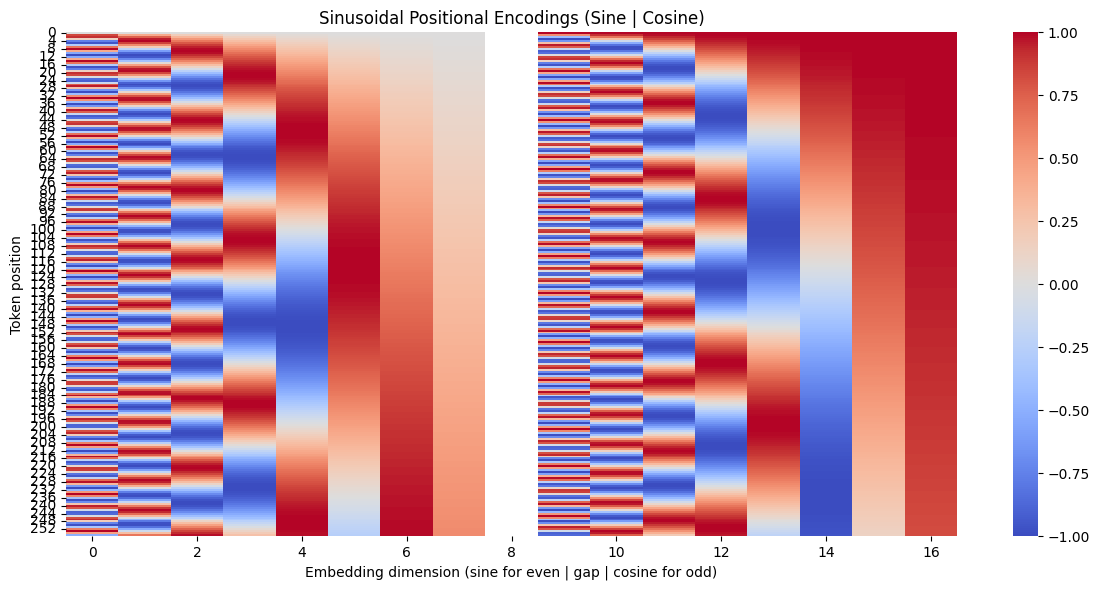

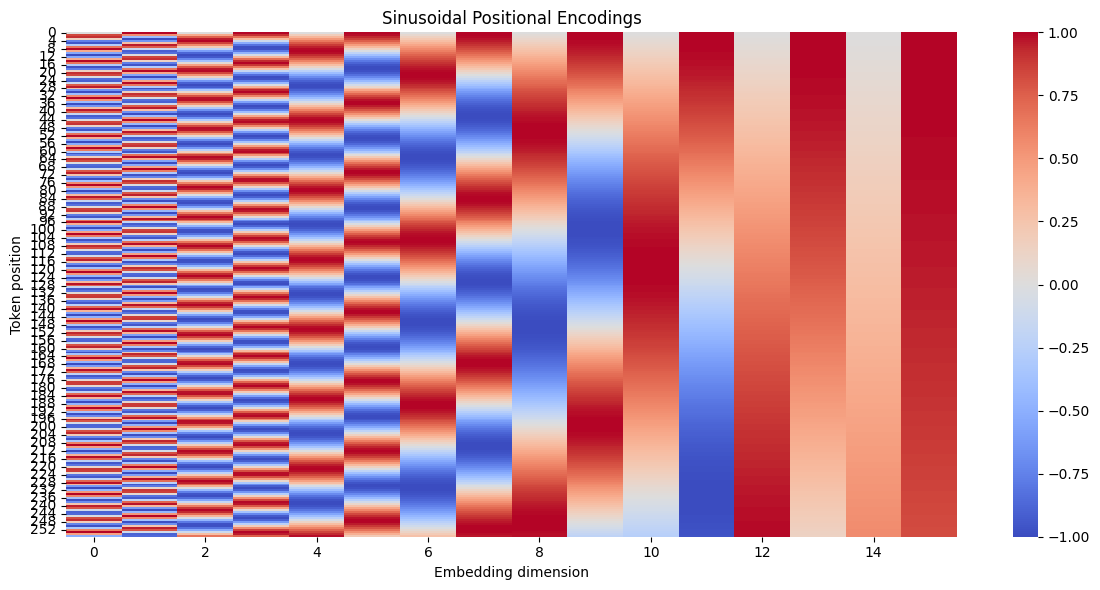

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Create sinusoidal matrix S
S = sinusoid_positions() # size: words, features

# Separate sine (even) and cosine (odd) components
sine = S[:, ::2]
cosine = S[:, 1::2]
gap = torch.full((S.size(0), 1), float('nan')).to(device)  # vertical separator

# Concatenate: [sine | gap | cosine]
S_sep = torch.cat([sine, gap, cosine], dim=1)

# Plot as heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(S_sep.cpu().numpy(), cmap="coolwarm", cbar=True, xticklabels=2, yticklabels=4)
plt.title("Sinusoidal Positional Encodings (Sine | Cosine)")
plt.xlabel("Embedding dimension (sine for even | gap | cosine for odd)")
plt.ylabel("Token position")
plt.tight_layout()
plt.show()

# Plot as heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(S.cpu().numpy(), cmap="coolwarm", cbar=True, xticklabels=2, yticklabels=4)
plt.title("Sinusoidal Positional Encodings")
plt.xlabel("Embedding dimension")
plt.ylabel("Token position")
plt.tight_layout()
plt.show()



# Recall the Attention Network
-----------------------

Working on cuda
Epoch 000 | Train Loss: 0.6470, Acc: 0.6264 | Val Loss: 0.5446, Acc: 0.7349
Epoch 001 | Train Loss: 0.4835, Acc: 0.7727 | Val Loss: 0.4356, Acc: 0.8048
Epoch 002 | Train Loss: 0.4187, Acc: 0.8133 | Val Loss: 0.4002, Acc: 0.8246
Epoch 003 | Train Loss: 0.3892, Acc: 0.8312 | Val Loss: 0.3807, Acc: 0.8340
Epoch 004 | Train Loss: 0.3713, Acc: 0.8416 | Val Loss: 0.3698, Acc: 0.8416
Epoch 005 | Train Loss: 0.3599, Acc: 0.8480 | Val Loss: 0.3635, Acc: 0.8456
Epoch 006 | Train Loss: 0.3511, Acc: 0.8528 | Val Loss: 0.3595, Acc: 0.8468
Epoch 007 | Train Loss: 0.3439, Acc: 0.8568 | Val Loss: 0.3568, Acc: 0.8477
Epoch 008 | Train Loss: 0.3376, Acc: 0.8601 | Val Loss: 0.3559, Acc: 0.8504
Epoch 009 | Train Loss: 0.3319, Acc: 0.8629 | Val Loss: 0.3547, Acc: 0.8505
Epoch 010 | Train Loss: 0.3251, Acc: 0.8663 | Val Loss: 0.3520, Acc: 0.8525
Epoch 011 | Train Loss: 0.3196, Acc: 0.8690 | Val Loss: 0.3526, Acc: 0.8532
Epoch 012 | Train Loss: 0.3149, Acc: 0.8710 | Val Loss: 0.3541, Acc: 0.8

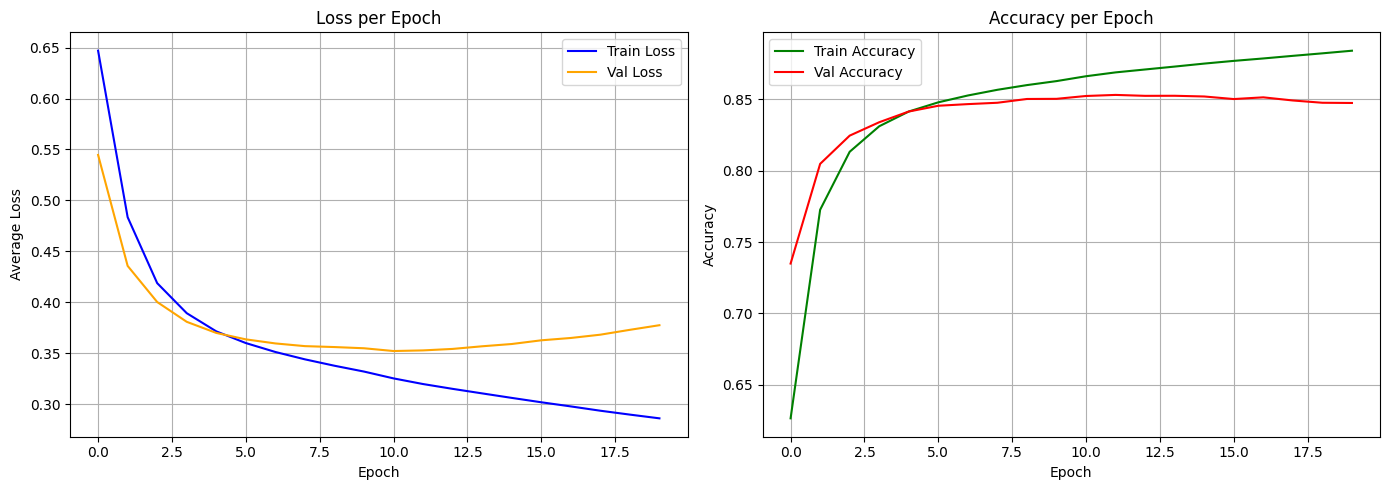

In [10]:
embed_cnt = 16          # word embeddings
pos_cnt = 16            # pos embeddings
feature_cnt = 16

vocab_len = max(vocab.values()) + 1   # maximal value (index) of a token

class Attention(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.energy = torch.nn.Linear(feature_cnt, 1)
    def forward(self, features):                        #SIZE: batch, words, features
        batch = features.size(0)          # get the batch dimension
        words = features.size(1)          # get the words dimension
        energies = self.energy(features)                #SIZE: batch, words, 1
        energies = energies.transpose(-2, -1)           #SIZE: batch, 1, words
        weights = F.softmax(energies, -1)               #SIZE: batch, 1, words
        features = weights @ features                   #SIZE: batch, 1, features
        return features

class Net_Attention_And_PE(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = torch.nn.Embedding(vocab_len, embed_cnt)
        self.attention = Attention()
        self.classifier = torch.nn.Linear(feature_cnt, 1)
    def forward(self, index):                            #SIZE: batch, words
        features = self.embedding(index) + S             #SIZE: batch, words, features

        ### This is where WHEIGHTED AVERAGING with LEARNED WEIGHTS takes place
        features = self.attention(features)              #SIZE: batch, 1, features

        classifications = self.classifier(features)      #SIZE: batch, 1, 1
        logits = classifications.squeeze(-1).squeeze(-1) #SIZE: batch
        return logits

net_att_pe = Net_Attention_And_PE()

# Execute training again
train_loss, val_loss, train_acc, val_acc = train_model(net_att_pe, train_loader, val_loader, epochs = 20)
plot_training_curves(train_loss, val_loss, train_acc, val_acc)

# Towards Self-Attention!
--------------------

We'll follow the same gradual approach as in the previous class.

At first, some changes may seem minor—perhaps even redundant—sometimes resulting in models that are equivalent, or worse: equivalent *and* overparameterized. But each step brings us closer to our goal.

And then, with one decisive twist, everything will fall into place.

So off we go!


## Introducing the Query and the Keys


So far, our attention mechanism has relied on letting the **Query** (which we previously called ***Energy*** but it is the same thing\) attend directly to the feature representations. But what if those raw features aren't always in the best form for comparison?

Instead of having the Query interact with features directly, we can transform each feature into a new vector—one that’s specifically designed to interact with the Query. This brings us to the concept of **Keys**.

Keys are learned projections of features that serve as their "presentation" when being evaluated by a Query. The idea is that attention will work better when both the **thing doing the looking** (Query) and the **thing being looked at** (Key) speak the same language.

Formally, we define the Key as:

$$
\text{key} = \text{feature} \cdot K
$$

where $K$ is a learnable matrix of shape $d \times d$, and $d$ is the dimensionality of the input features.


In [11]:
embed_cnt = 16          # word embeddings
pos_cnt = 16            # pos embeddings
feature_cnt = 16

vocab_len = max(vocab.values()) + 1   # maximal value (index) of a token

class Attention_With_Keys(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.query = torch.nn.Linear(feature_cnt, 1)            # rename energy to query from now on
        self.K = torch.nn.Linear(feature_cnt, feature_cnt)      # and introduce the K (key) matrix d x d
    def forward(self, features):                        #SIZE: batch, words, features
        batch = features.size(0)          # get the batch dimension
        words = features.size(1)          # get the words dimension
        keys = self.K(features)                         #SIZE: batch, words, features
        energies = self.query(keys)                     #SIZE: batch, words, 1
        energies = energies.transpose(-2, -1)           #SIZE: batch, 1, words
        weights = F.softmax(energies, -1)               #SIZE: batch, 1, words
        features = weights @ features                   #SIZE: batch, 1, features
        return features

class Net_Attention_With_Keys(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = torch.nn.Embedding(vocab_len, embed_cnt)
        self.attention = Attention_With_Keys()
        self.classifier = torch.nn.Linear(feature_cnt, 1)
    def forward(self, index):                            #SIZE: batch, words
        features = self.embedding(index) + S             #SIZE: batch, words, features

        ### This is where WHEIGHTED AVERAGING with LEARNED WEIGHTS takes place
        features = self.attention(features)              #SIZE: batch, 1, features

        classifications = self.classifier(features)      #SIZE: batch, 1, 1
        logits = classifications.squeeze(-1).squeeze(-1) #SIZE: batch
        return logits


### Task

Obviously, this query-key formulation is not only equivalent to the regular energy-focused attention. It is redundant in terms of parameters. Do you see that?



### Query-Key vs. Energy Formulation Comparison

Let’s compare two formulations for computing attention energies from feature vectors.


#### Query-Key Factorized Version

In our current model, we compute:

$$
\text{keys} = \text{features} \cdot K \\
\text{energies} = \text{keys} \cdot q = (\text{features} \cdot K) \cdot q = \text{features} \cdot (K \cdot q)
$$

So although we introduce **Keys** and **Queries** explicitly, the final result is still a single linear projection of the original features:

$$
\text{energies} = \text{features} \cdot W, \quad \text{where} \quad W = K \cdot q
$$

This is functionally equivalent to the classic **energy-only** attention mechanism.


#### Parameter Count

Let $d$ be the dimensionality of the features (i.e., `feature_cnt`).

- **Query-Key version:**
  - $K$: a $d \times d$ matrix, resulting in $d^2$ parameters
  - $q$: a $d \times 1$ vector, resulting in $d$ parameters  
  
  **Total: $d^2 + d$ parameters**

- **Energy-only version:**
  - A single linear layer from features to scalar
  
  **Total: $d$ parameters**

So, in this setup, the query-key formulation has **$d^2$ more parameters** than necessary and is **strictly overparameterized**.





#### Conclusion

This setup offers **no additional expressivity**. In fact, unless carefully initialized or regularized, it can make learning harder and less stable due to the redundant parameterization.


### Low-Rank Factorization

Not all is lost. By carefully controlling the dimensionality of the **Key space**, we can reduce the number of parameters and limit overparameterization.

Let’s introduce a **low-rank factorization**:

- $K$: a $d \times k$ matrix  
- $q$: a $k \times 1$ vector  
- where $k < d$

Then the energy computation becomes:

$$
\text{keys} = \text{features} \cdot K  \\
\text{energies} = \text{keys} \cdot q = \text{features} \cdot (K \cdot q)
$$

So again:

$$
\text{energies} = \text{features} \cdot W, \quad \text{with } W = K \cdot q \in \mathbb{R}^{d \times 1}
$$



####  Parameter Count

Let’s compare the number of parameters:

- **Low-rank query-key version:**
  - $K$: $d \times k$ → $dk$ parameters
  - $q$: $k \times 1$ → $k$ parameters  
  **Total: $dk + k$ parameters**

- **Original energy-only version:**
  - One linear projection: $d$ parameters

Notably, when $k = 1$, the number of parameters becomes:

  $$
  d \cdot 1 + 1 = d + 1
  $$

  —which **exactly matches** the parameter count of the original energy-only formulation with a single linear projection.


#### Conclusion

We started off with a version that was **theoretically equivalent but practically worse** than the original energy-based attention. By factorizing the energy computation into separate **Key** and **Query** components without reducing dimensionality, we introduced unnecessary overparameterization—making the model **less stable** and harder to train.

However, this detour was not without value: it led us to a more flexible and efficient formulation. By **reducing the dimensionality** of the key space (i.e., using a smaller $k$), we arrive at a **low-rank factorization** that:

- Matches the original model’s parameter count when $k = 1$,
- And enables richer attention structures when $k > 1$.

So while our initial formulation was redundant, it ultimately revealed a **useful and scalable path forward**.

We will not be training this version, as thanks to this careful analysis, we do not expect nothing valuable to come out of it.


## Introducing Queries

Up to now, we’ve used a **single, global query** to compute attention scores over all tokens in the sequence. This gave us a fixed viewpoint—useful for tasks like classification—but it limited the model's ability to express interactions between tokens.

In **self-attention**, we take this idea further: **each token generates its own query**.

A **Query** is a learned projection of a token’s features that expresses **what this token is looking for**. Instead of one global viewpoint, every token forms its own question and compares it against the rest of the sequence.

To do this, we introduce a learnable matrix $Q$ of shape $d \times k$, where:
- $d$ is the dimensionality of the feature vector,
- $k$ is the dimensionality of the shared **query and key space**.

Each query is computed as:

$$
\text{query} = \text{feature} \cdot Q
$$

Likewise, each key is computed as:

$$
\text{key} = \text{feature} \cdot K
$$

where $K$ is another learned matrix of shape $d \times k$.

We then compute attention scores using a dot product between the query of one token and the keys of all tokens in the sequence:

$$
\text{energy}_{i,j} = \text{query}_i \cdot \text{key}_j
$$

This produces a separate attention distribution **for each token**—each one deciding independently which other tokens to attend to.

This mechanism is the heart of self-attention: it turns every token into an active agent that selectively gathers information from its surroundings.


### Matrix Formulation


Let’s now express this more generally in matrix form.

Let:
- $F \in \mathbb{R}^{n \times d}$ be the matrix of input features (for $n$ tokens, each of dimension $d$),
- $Q \in \mathbb{R}^{d \times k}$ be the **query projection matrix**,
- $K \in \mathbb{R}^{d \times k}$ be the **key projection matrix**.

We compute:
- Queries: $F Q \in \mathbb{R}^{n \times k}$
- Keys: $F K \in \mathbb{R}^{n \times k}$

The attention **energy matrix** is then:

$$
E = (F Q)(F K)^\top \in \mathbb{R}^{n \times n}
$$

Now comes the crucial observation:

We can factor the expression as:

$$
E = F (Q K^\top) F^\top
$$

This shows that the full $n \times n$ energy matrix is a **quadratic form** defined by the product $Q K^\top \in \mathbb{R}^{d \times d}$.



### Parameter Count

- $Q$: $d \times k$, resulting in $dk$ parameters  
- $K$: $d \times k$, resulting in $dk$ parameters  

**Total: $2dk$ parameters**

- The matrix $Q K^\top \in \mathbb{R}^{d \times d}$ is a **learned, structured weight matrix**, but it is **not arbitrary** — it is parameterized by just $2dk$ parameters, not $d^2$.

So although $Q K^\top$ is a $d \times d$ matrix, it has **rank at most $k$**, and it is **not directly learned**, but **composed** from two lower-rank projections.

### Conclusion

- The energy matrix $E \in \mathbb{R}^{n \times n}$ is expressed as:
  $$
  E = F (Q K^\top) F^\top
  $$
- This shows that attention energies are governed by a **global bilinear interaction** over the features.
- The structure $Q K^\top$ has rank at most $k$ and is fully determined by $2dk$ parameters.
- For $k \ll d$, this formulation yields a **low-rank attention mechanism** that is both expressive and efficient — far more efficient than a full, unconstrained $d \times d$ attention matrix.

**This is theory - in practice overparametrization may help, you are free to experiment even with the following examples with raising $k$ to 16.**

Working on cuda
Epoch 000 | Train Loss: 0.6315, Acc: 0.6387 | Val Loss: 0.5308, Acc: 0.7433
Epoch 001 | Train Loss: 0.4715, Acc: 0.7816 | Val Loss: 0.4308, Acc: 0.8066
Epoch 002 | Train Loss: 0.4081, Acc: 0.8200 | Val Loss: 0.3942, Acc: 0.8279
Epoch 003 | Train Loss: 0.3766, Acc: 0.8367 | Val Loss: 0.3751, Acc: 0.8355
Epoch 004 | Train Loss: 0.3608, Acc: 0.8454 | Val Loss: 0.3646, Acc: 0.8421
Epoch 005 | Train Loss: 0.3504, Acc: 0.8504 | Val Loss: 0.3587, Acc: 0.8471
Epoch 006 | Train Loss: 0.3418, Acc: 0.8551 | Val Loss: 0.3524, Acc: 0.8501
Epoch 007 | Train Loss: 0.3342, Acc: 0.8588 | Val Loss: 0.3480, Acc: 0.8512
Epoch 008 | Train Loss: 0.3276, Acc: 0.8621 | Val Loss: 0.3466, Acc: 0.8527
Epoch 009 | Train Loss: 0.3215, Acc: 0.8654 | Val Loss: 0.3458, Acc: 0.8525
Epoch 010 | Train Loss: 0.3160, Acc: 0.8678 | Val Loss: 0.3455, Acc: 0.8532
Epoch 011 | Train Loss: 0.3109, Acc: 0.8702 | Val Loss: 0.3460, Acc: 0.8537
Epoch 012 | Train Loss: 0.3058, Acc: 0.8727 | Val Loss: 0.3479, Acc: 0.8

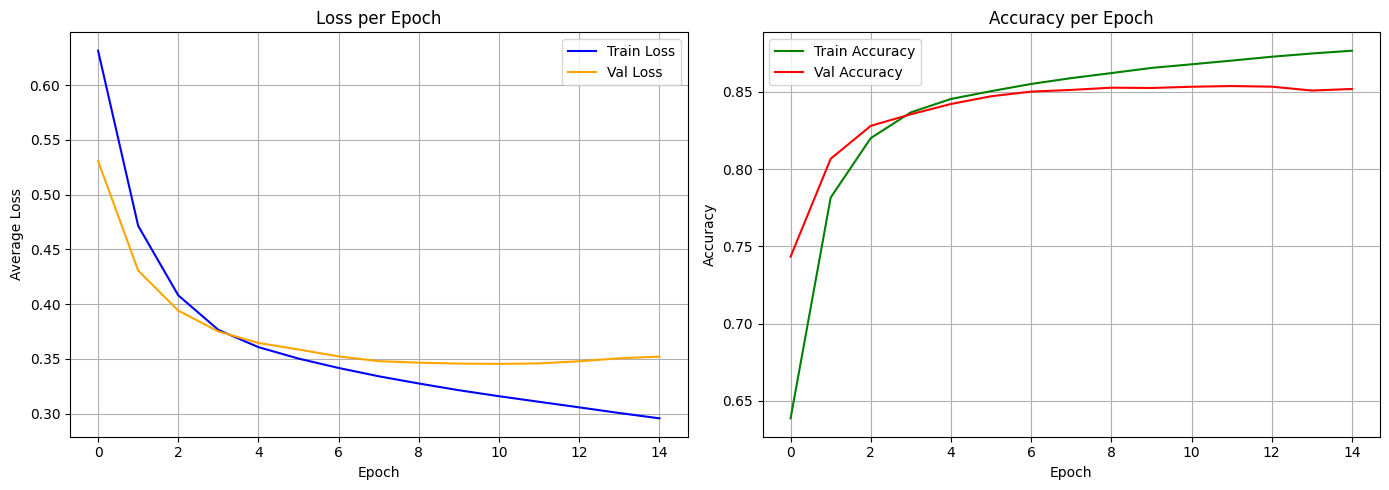

In [12]:
embed_cnt = 16          # word embedding dimension
pos_cnt = 16            # positional encoding dimension
feature_cnt = 16        # total feature dimension (d)
k = 8                   # query/key dimension (low-rank)

vocab_len = max(vocab.values()) + 1  # maximal value (index) of a token

class SelfAttention_QK(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.Q = torch.nn.Linear(feature_cnt, k)        # query projection d x k
        self.K = torch.nn.Linear(feature_cnt, k)        # key projection d x k
        self.attention = None  # will store softmaxed attention weights for inspection later

    def forward(self, features):                        # size: batch, words, d
        queries = self.Q(features)                      # size: batch, words, k
        keys = self.K(features)                         # size: batch, words, k

        # Compute energy scores:
        energies = queries @ keys.transpose(-2, -1)     # size: batch, words, words
        energies = energies / (k ** 0.5)                # it is an additional rescale helping the stability

        # Normalize energies into attention weights
        self.attention = F.softmax(energies, dim=-1)         # size: batch, words, words

        # Apply attention weights to values:
        output = self.attention @ features                   # size: batch, words, d

        return output

class Net_SelfAttention_QK(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = torch.nn.Embedding(vocab_len, embed_cnt)
        self.attention = SelfAttention_QK()
        self.classifier = torch.nn.Linear(feature_cnt, 1)

    def forward(self, index):                            # size: batch, words
        features = self.embedding(index) + S             # size: batch, words, d

        # Attend and pool original features using attention weights
        attended = self.attention(features)              # size: batch, words, d
        pooled = attended.mean(dim = -2)                 # size: batch, d  # average across words

        output = self.classifier(pooled)                 # size: batch, 1
        logits = output.squeeze(-1)                      # size: batch
        return logits

# Instantiate and train
net_att_qk = Net_SelfAttention_QK()
train_loss, val_loss, train_acc, val_acc = train_model(net_att_qk, train_loader, val_loader, epochs=12)
plot_training_curves(train_loss, val_loss, train_acc, val_acc)


### Why divide by $\sqrt{k}$?

Recall that attention energies are computed as:

$$
\text{energy}_{i,j} = \text{query}_i \cdot \text{key}_j = \sum_{l=1}^{k} q_{i,l} \cdot k_{j,l}
$$

This is an unnormalized dot product of two $k$-dimensional vectors.

Assume:

$$
q_{i,l} \sim \mathcal{N}(0, \sigma^2), \quad k_{j,l} \sim \mathcal{N}(0, \sigma^2)
$$

Then the dot product is a sum of $k$ independent products, so its variance is proportional to $k$:

$$
\text{Var}(q_i \cdot k_j) \propto k
$$



**What goes wrong without scaling?**

As $k$ increases, the magnitude of these raw energies grows. When passed through the softmax, this leads to **very sharp distributions** — with outputs close to 0 or 1. This causes:

- Vanishing gradients in early training,
- Unstable or brittle updates,
- Poor generalization.



**The fix: divide by $\sqrt{k}$**

To stabilize this, we rescale the energies:

$$
\text{energy}_{i,j} = \frac{q_i \cdot k_j}{\sqrt{k}}
$$

This keeps the scale of energies roughly constant as $k$ grows, ensuring that softmax remains smooth and gradients stay usable.

This was introduced in the original Transformer paper: *Attention is All You Need*, so we introduce it a bit early, but we want the training to be stable.

## Introducing Values

So far, we’ve seen how **Queries** and **Keys** determine *where* attention should be paid — that is, which tokens are relevant to each other. But once the model has computed these attention **energies**, what exactly is being retrieved?

This is the role of **Values**.

Each token is associated with a **value vector** — a projection of its features that represents the *content* it offers if attended to. These are computed just like queries and keys:

$$
\text{value} = \text{feature} \cdot V
$$

where:
- $\text{feature} \in \mathbb{R}^d$ is the input feature vector for a single token,
- $V \in \mathbb{R}^{d \times d_v}$ is a learnable weight matrix,
- $\text{value} \in \mathbb{R}^{d_v}$ is the resulting value vector.

For a batch of $n$ tokens, this gives:

$$
\text{values} = F \cdot V \in \mathbb{R}^{n \times d_v}
$$

The attention mechanism computes a matrix of **energies**:

$$
E = F \cdot (QK^\top) \cdot F^\top \in \mathbb{R}^{n \times n}
$$

These energies encode which tokens should influence each other — but not what is being transferred. To actually compute the result of attention, we combine these (after row-wise normalization) with the value vectors:

$$
\text{output} = \text{weights} \cdot \text{values}
$$

where `weights` is obtained from $E$ by applying softmax or another normalization function row-wise.



Working on cuda
Epoch 000 | Train Loss: 0.6174, Acc: 0.6411 | Val Loss: 0.5079, Acc: 0.7516
Epoch 001 | Train Loss: 0.4625, Acc: 0.7847 | Val Loss: 0.4231, Acc: 0.8094
Epoch 002 | Train Loss: 0.3997, Acc: 0.8214 | Val Loss: 0.3850, Acc: 0.8294
Epoch 003 | Train Loss: 0.3709, Acc: 0.8364 | Val Loss: 0.3667, Acc: 0.8377
Epoch 004 | Train Loss: 0.3533, Acc: 0.8453 | Val Loss: 0.3578, Acc: 0.8430
Epoch 005 | Train Loss: 0.3414, Acc: 0.8516 | Val Loss: 0.3505, Acc: 0.8460
Epoch 006 | Train Loss: 0.3321, Acc: 0.8560 | Val Loss: 0.3471, Acc: 0.8474
Epoch 007 | Train Loss: 0.3241, Acc: 0.8601 | Val Loss: 0.3442, Acc: 0.8493
Epoch 008 | Train Loss: 0.3168, Acc: 0.8635 | Val Loss: 0.3426, Acc: 0.8501
Epoch 009 | Train Loss: 0.3103, Acc: 0.8667 | Val Loss: 0.3421, Acc: 0.8501
Epoch 010 | Train Loss: 0.3042, Acc: 0.8693 | Val Loss: 0.3426, Acc: 0.8497
Epoch 011 | Train Loss: 0.2985, Acc: 0.8719 | Val Loss: 0.3440, Acc: 0.8499
Epoch 012 | Train Loss: 0.2931, Acc: 0.8745 | Val Loss: 0.3445, Acc: 0.8

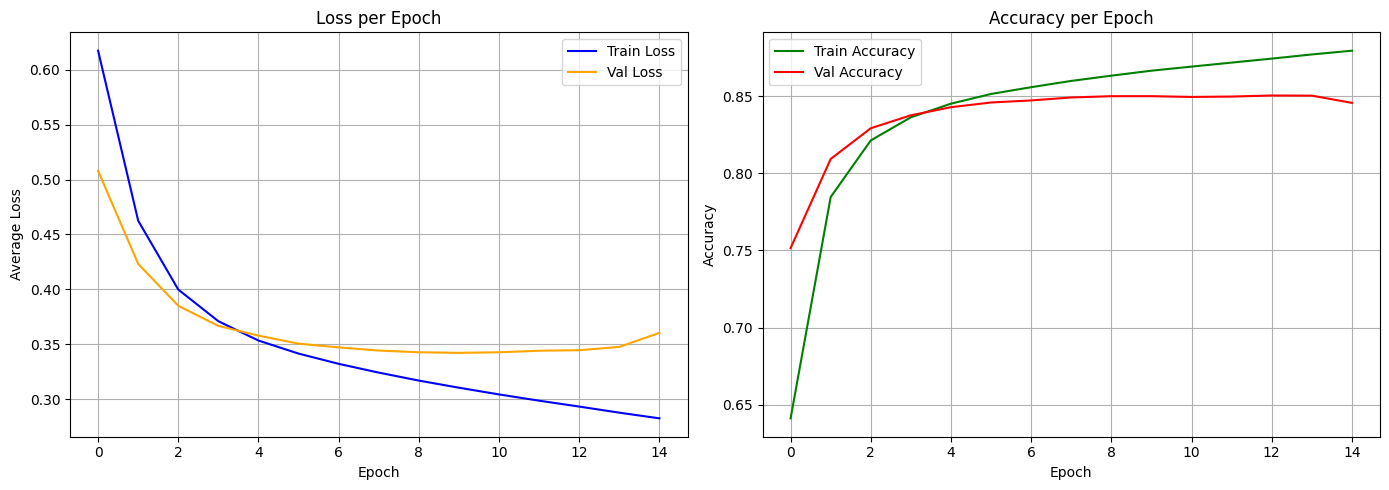

In [13]:
embed_cnt = 16          # word embedding dimension
pos_cnt = 16            # positional encoding dimension
feature_cnt = 16        # total feature dimension (d)
k = 8                  # query/key dimension (low-rank)
d_v = feature_cnt       # output value dimension (could be different if desired)

vocab_len = max(vocab.values()) + 1 # maximal value (index) of a token

class SelfAttention(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.Q = torch.nn.Linear(feature_cnt, k)        # query projection d x k
        self.K = torch.nn.Linear(feature_cnt, k)        # key projection d x k
        self.V = torch.nn.Linear(feature_cnt, d_v)      # value projection d x d_v
        self.attention = None  # will store softmaxed attention weights for inspection later

    def forward(self, features):                        # size: batch, words, d
        queries = self.Q(features)                      # size: batch, words, k
        keys = self.K(features)                         # size: batch, words, k
        values = self.V(features)                       # size: batch, words, d_v

        # Compute energy scores:
        energies = queries @ keys.transpose(-2, -1)     # size: batch, words, words
        energies = energies / (k ** 0.5)                # it is an additional rescale helping the stability

        # Normalize energies into attention weights
        self.attention = F.softmax(energies, dim=-1)         # size: batch, words, words

        # Apply attention weights to values:
        output = self.attention @ values                     # size: batch, words, d_v

        return output

class Net_SelfAttention(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = torch.nn.Embedding(vocab_len, embed_cnt)
        self.attention = SelfAttention()
        self.classifier = torch.nn.Linear(d_v, 1)

    def forward(self, index):                            # size: batch, words
        features = self.embedding(index) + S             # size: batch, words, d

        # Attend and pool original features using attention weights
        attended = self.attention(features)              # size: batch, words, d_v
        pooled = attended.mean(dim = -2)                 # size: batch, d_v  # average across words

        output = self.classifier(F.relu(pooled))         # size: batch, 1     # Note, that we add a nonlinearity to avoid collapsing two subsequent linear operators: V and then the classifier layer
        logits = output.squeeze(-1)                      # size: batch
        return logits

# Instantiate and train
net_selfatt = Net_SelfAttention()
train_loss, val_loss, train_acc, val_acc = train_model(net_selfatt, train_loader, val_loader, epochs=15)
plot_training_curves(train_loss, val_loss, train_acc, val_acc)


## Wall Times for the Above Code

- **Without GPU** it takes 9500 seconds, roughly 3 hours runtime.
- **With GPU** it takes less than 300 seconds, some fourish minutes.

And these are cheap free Colab GPUs.

## Conclusion

Now we have transitioned to self-attention, where each token gets:

- Its own query (what it's looking for),
- Its own key (how it presents itself),
- Its own value (what it offers if attended to)

# Visualising Attention
-------------------

After those 3 runs we can see on the validation task, that the best model so far was the Query-Key model, but adding the Value part didn't help. So we are retaining the Query-Key model for visualisation and tests.

In [14]:

def visualize_attention(sentence, model):
    # Tokenize and convert to input IDs
    tokens = tokenize(sentence)
    input_ids = pad(tokens_to_ids(tokens, vocab))
    indices = torch.tensor([input_ids]).to(device)  # shape: (1, max_len)

    # Run the model (stores attention in model.attention.attention)
    model.eval()
    with torch.no_grad():
        logits = model(indices)  # shape: (1,)
        pred = logits.item()
        label = label_map[int(pred > 0)]  # 0 if logit ≤ 0, 1 if logit > 0

    # Extract attention matrix (batch size = 1)
    attention = model.attention.attention[0].detach().cpu().numpy()

    # Compute length: all non-PADs + first N_PAD pads
    pad_token = vocab.get('<PAD>', 0)
    non_pad_len = sum(1 for idx in input_ids if idx != pad_token)
    N_PAD = 20
    visual_len = min(non_pad_len + N_PAD, len(input_ids))

    # Extend tokens with <PAD> to match visual length
    tokens = tokens + ['<PAD>'] * (visual_len - non_pad_len)
    attention = attention[:visual_len, :visual_len]

    # Print sentence and predicted class
    print(f"\nSentence: {' '.join(tokens[:non_pad_len])}")
    print(f"Predicted: {label} with a logit of {pred}")

    # Plot attention matrix
    plt.figure(figsize=(16, 12))
    sns.heatmap(attention, xticklabels=tokens, yticklabels=tokens, cmap="viridis")
    plt.title(f"Self-Attention: '{sentence}'")
    plt.xlabel("Attended to")
    plt.ylabel("Query position")
    plt.tight_layout()
    plt.show()


Sentence: this is a distractor sentence that does not do much good but is present here for laugs separatortoken i love this place so much it is so good to be here but the beaty of my companion was a distraction
Predicted: positive with a logit of 3.935495376586914


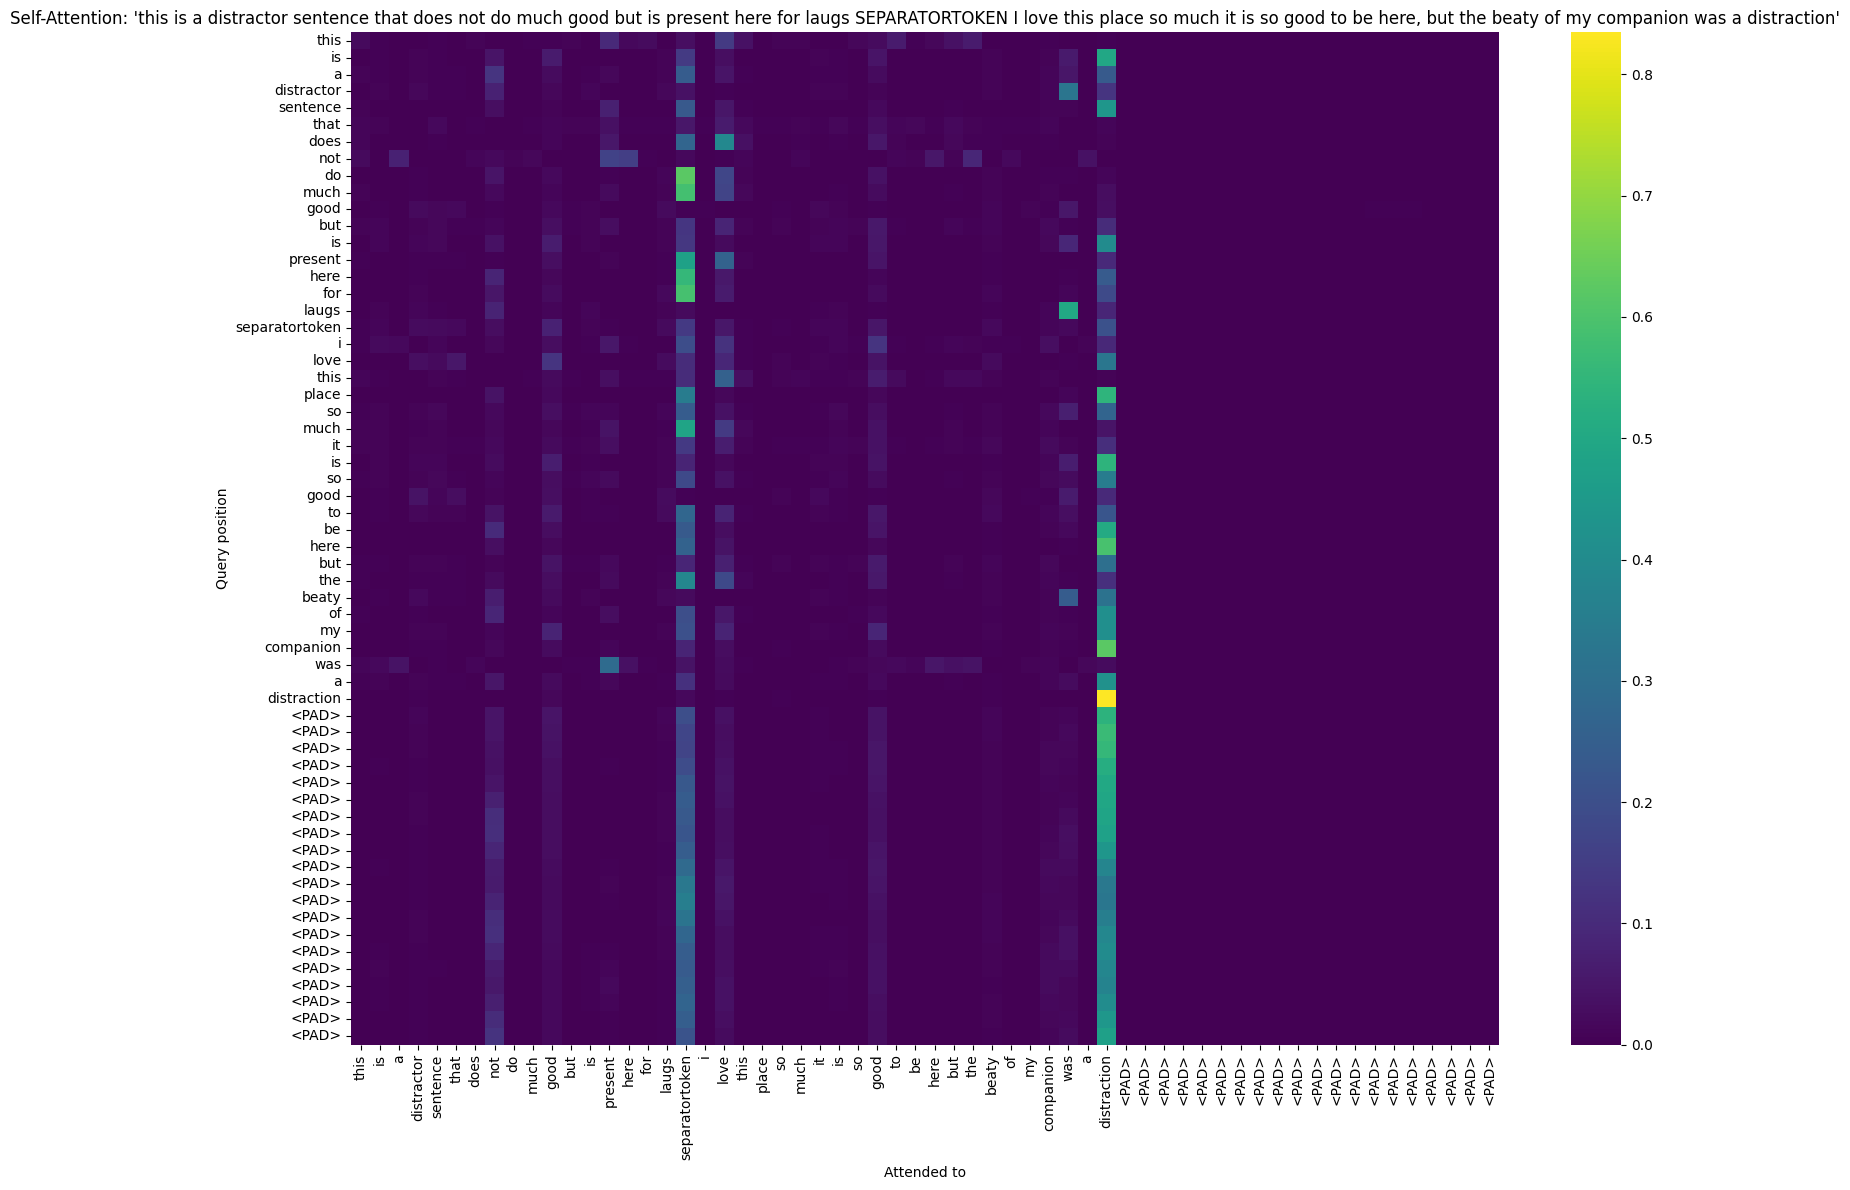


Sentence: this is a distractor sentence that does not do much good but is present here for hmm separatortoken i don t love this place so much it is not so good at all to be here
Predicted: negative with a logit of -0.46329420804977417


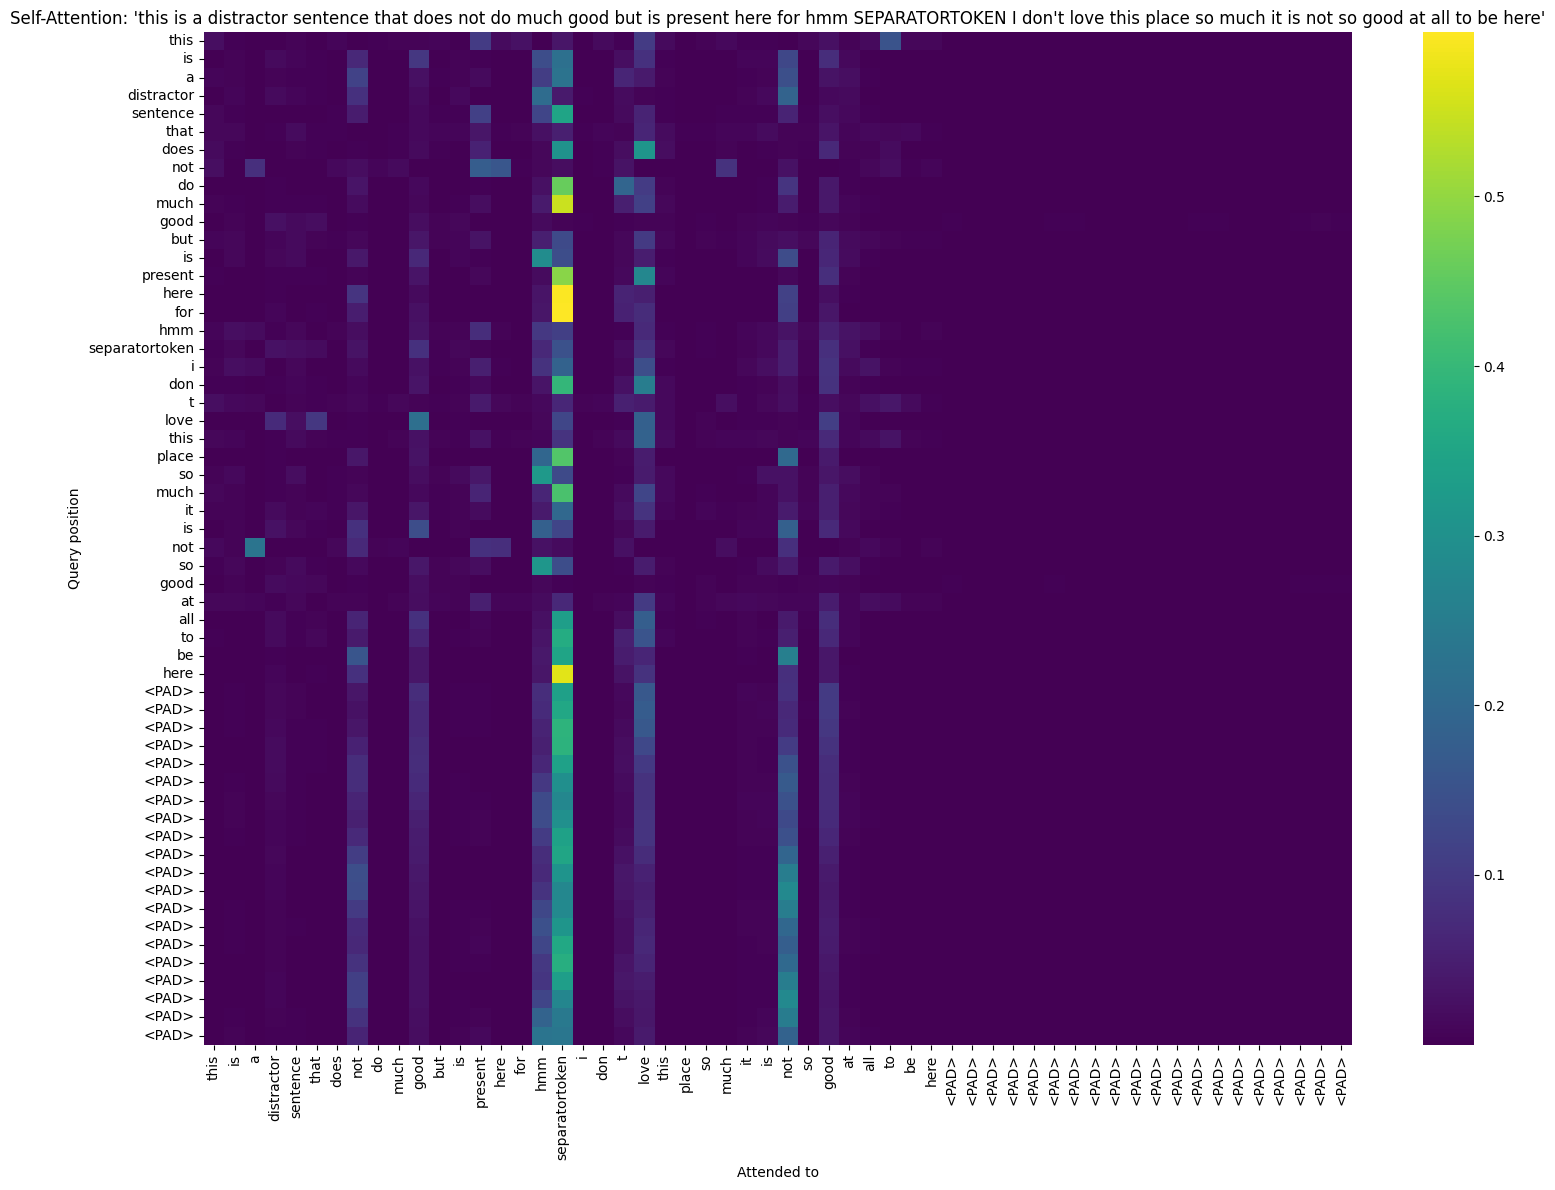


Sentence: this is a distractor sentence that does not do much good but is present here for distraction separatortoken food was great and music was making me very nostalgic but the service was completely terrible
Predicted: negative with a logit of -1.4189101457595825


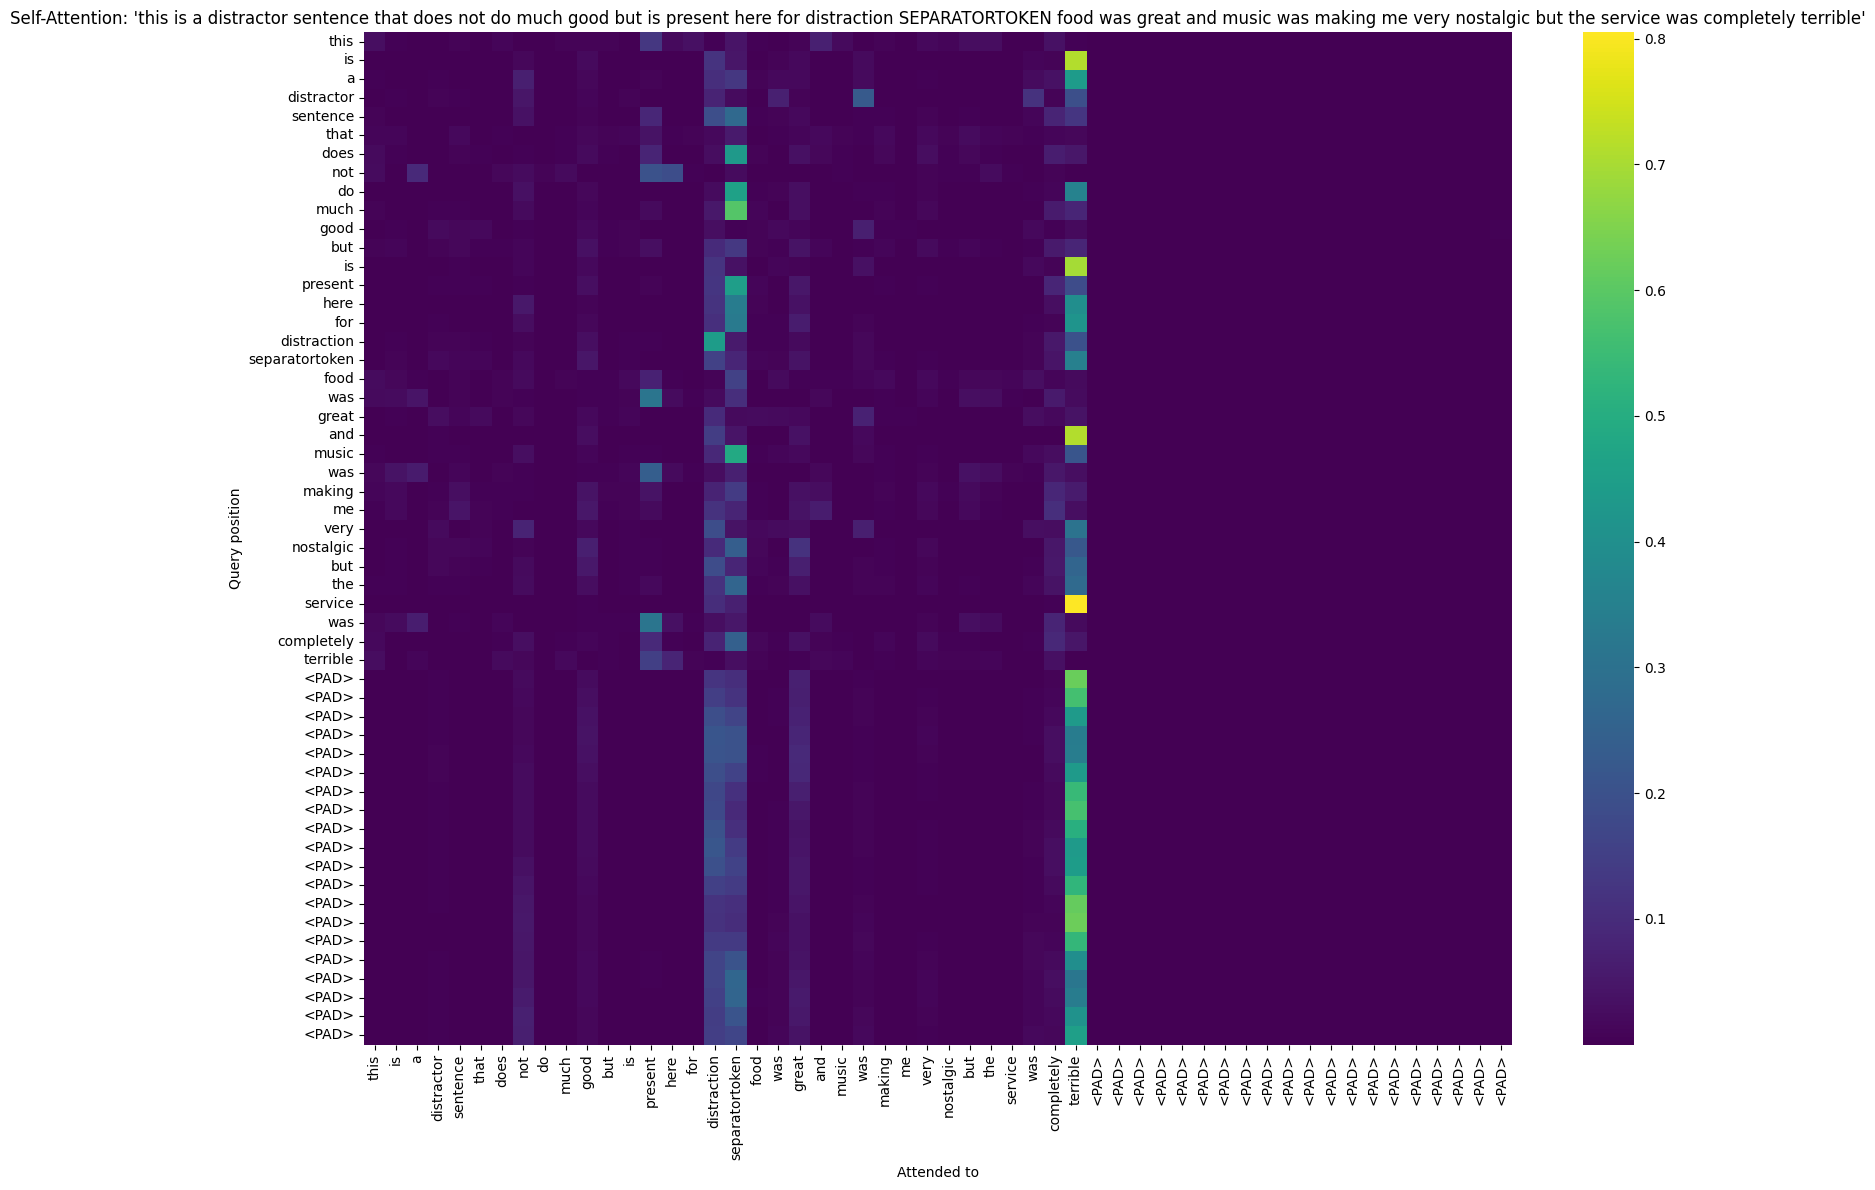


Sentence: this is a distractor sentence that does not do much good but is present here anyway separatortoken food was great and music was making me very nostalgic and even the service was not completely terrible
Predicted: negative with a logit of -2.7719645500183105


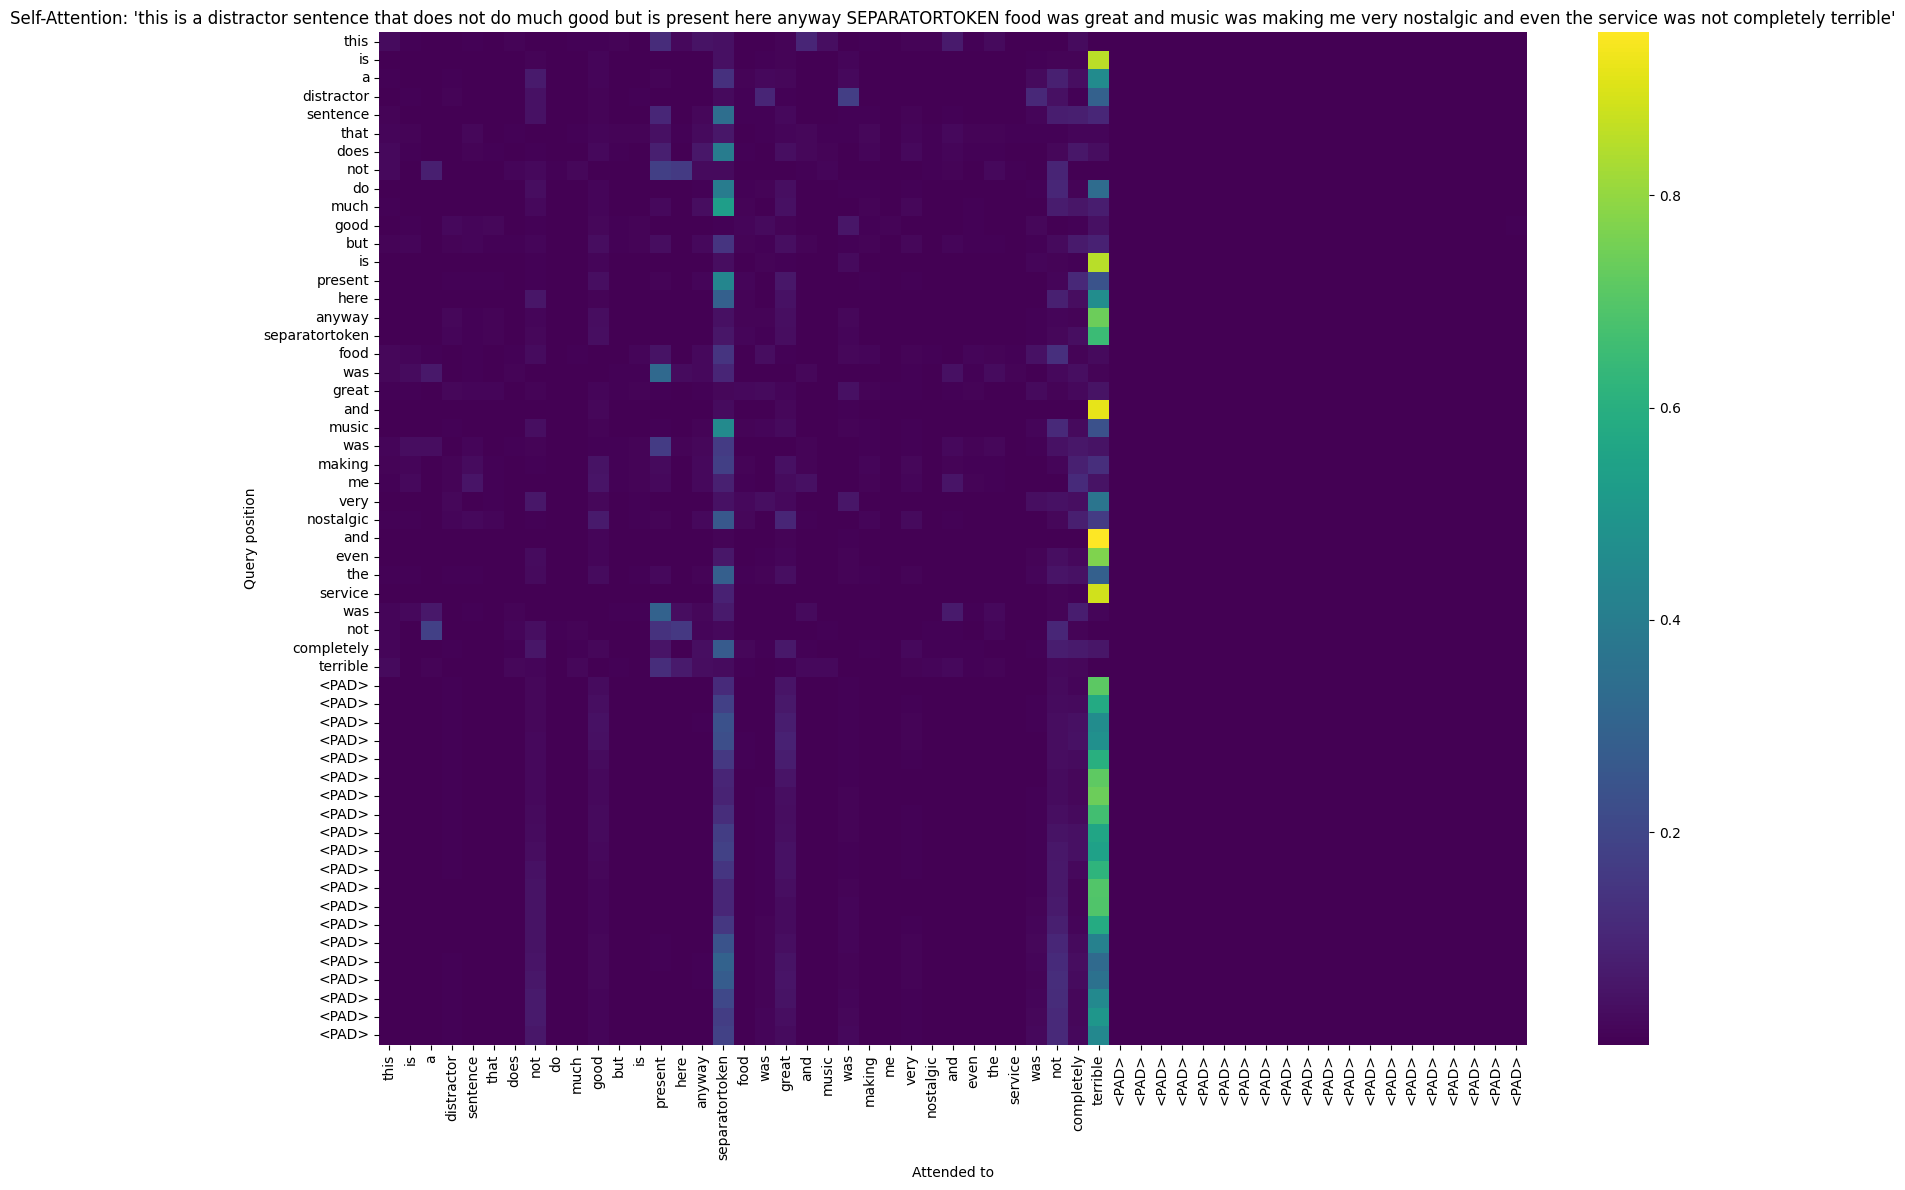


Sentence: nothing to see here really just a bit of noise before we start this slightly longer filler to simulate context separatortoken i absolutely loved the energy of the staff and how attentive they were to every detail from the welcome at the door to the friendly goodbye at the end
Predicted: positive with a logit of 2.0421297550201416


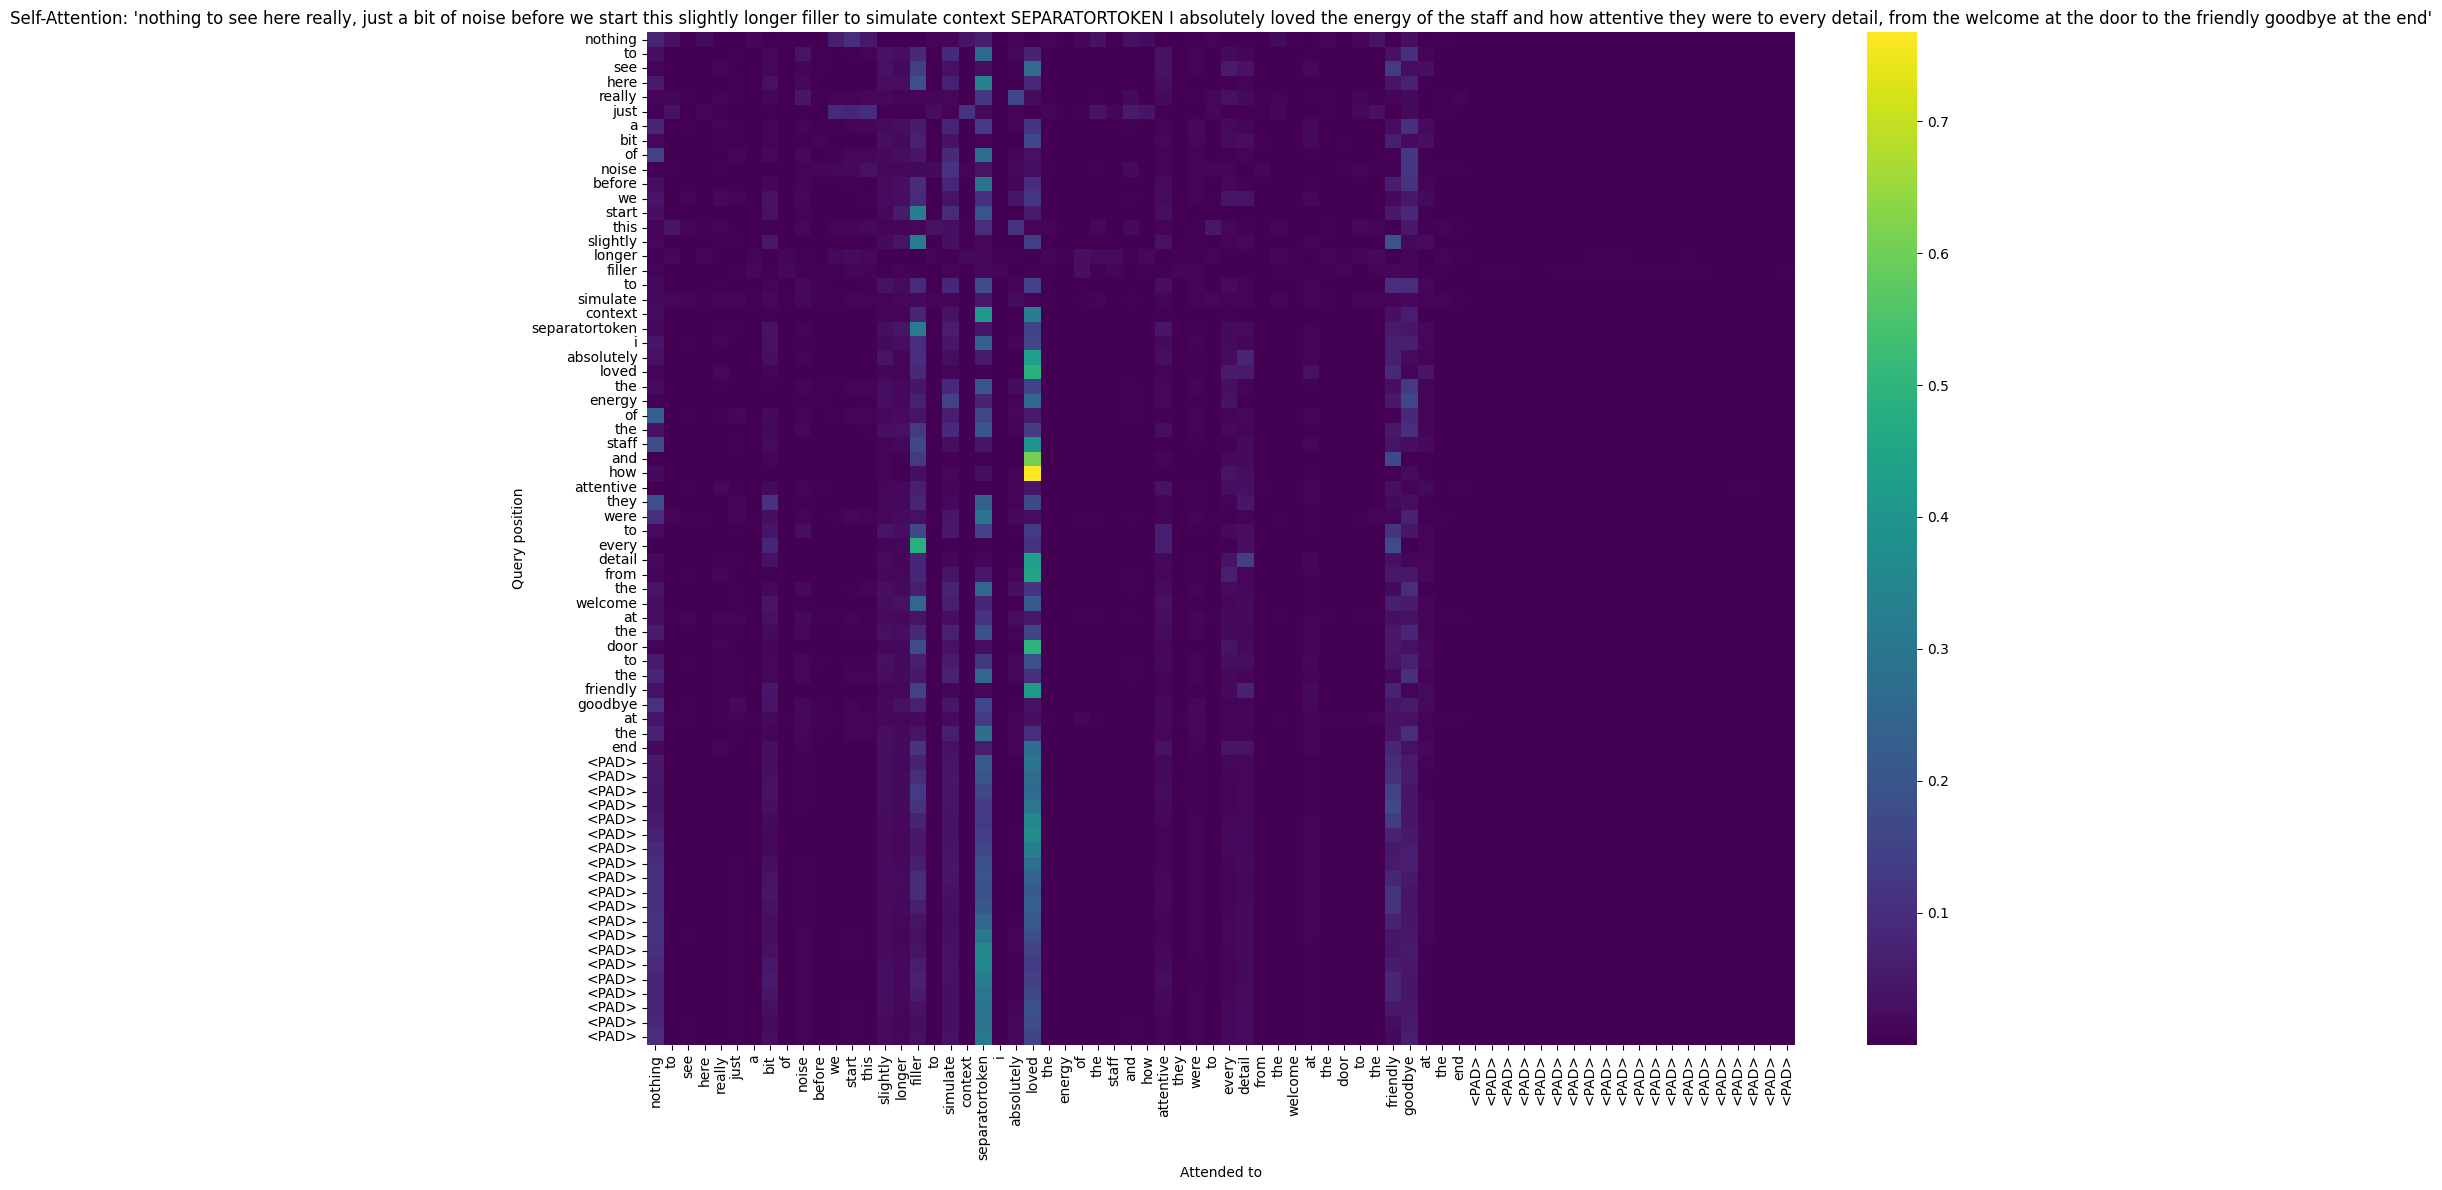


Sentence: ignore this beginning part it s just here to waste a few words and create the illusion of complexity in the setup separatortoken the experience was underwhelming from bland food to a cold and uninviting atmosphere that made us wish we d stayed home instead of coming out
Predicted: negative with a logit of -4.080688953399658


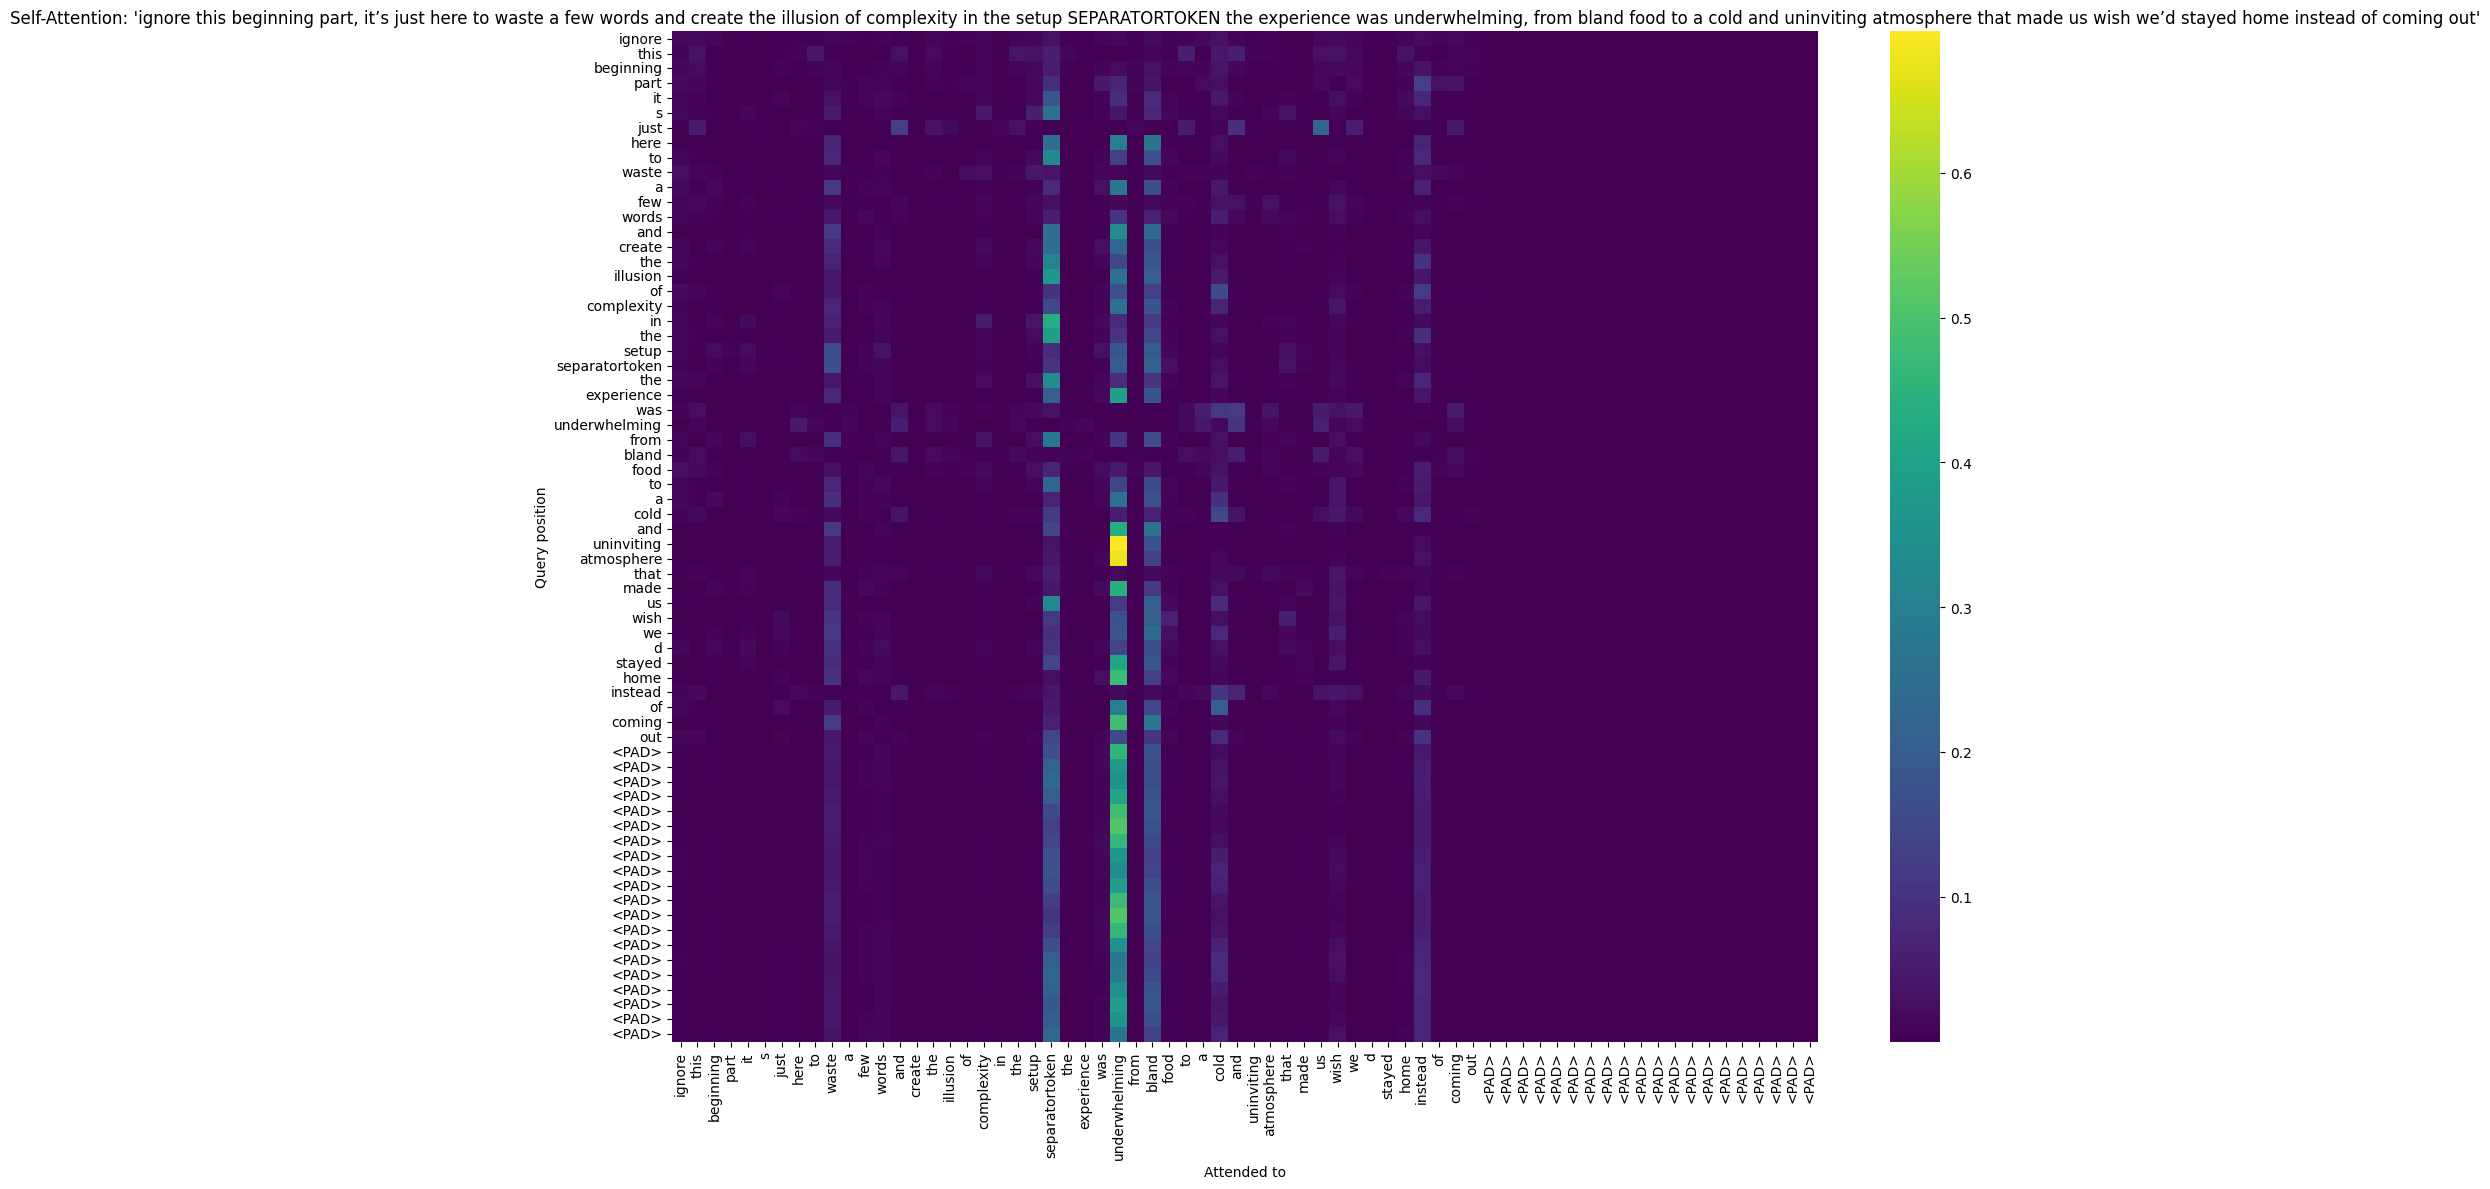


Sentence: some random intro text that doesn t mean much at all and is mostly here to make the sentence look more interesting separatortoken the flavors were rich and authentic making it one of the best meals i ve had this year and the chef clearly understands balance and depth
Predicted: positive with a logit of 4.2751007080078125


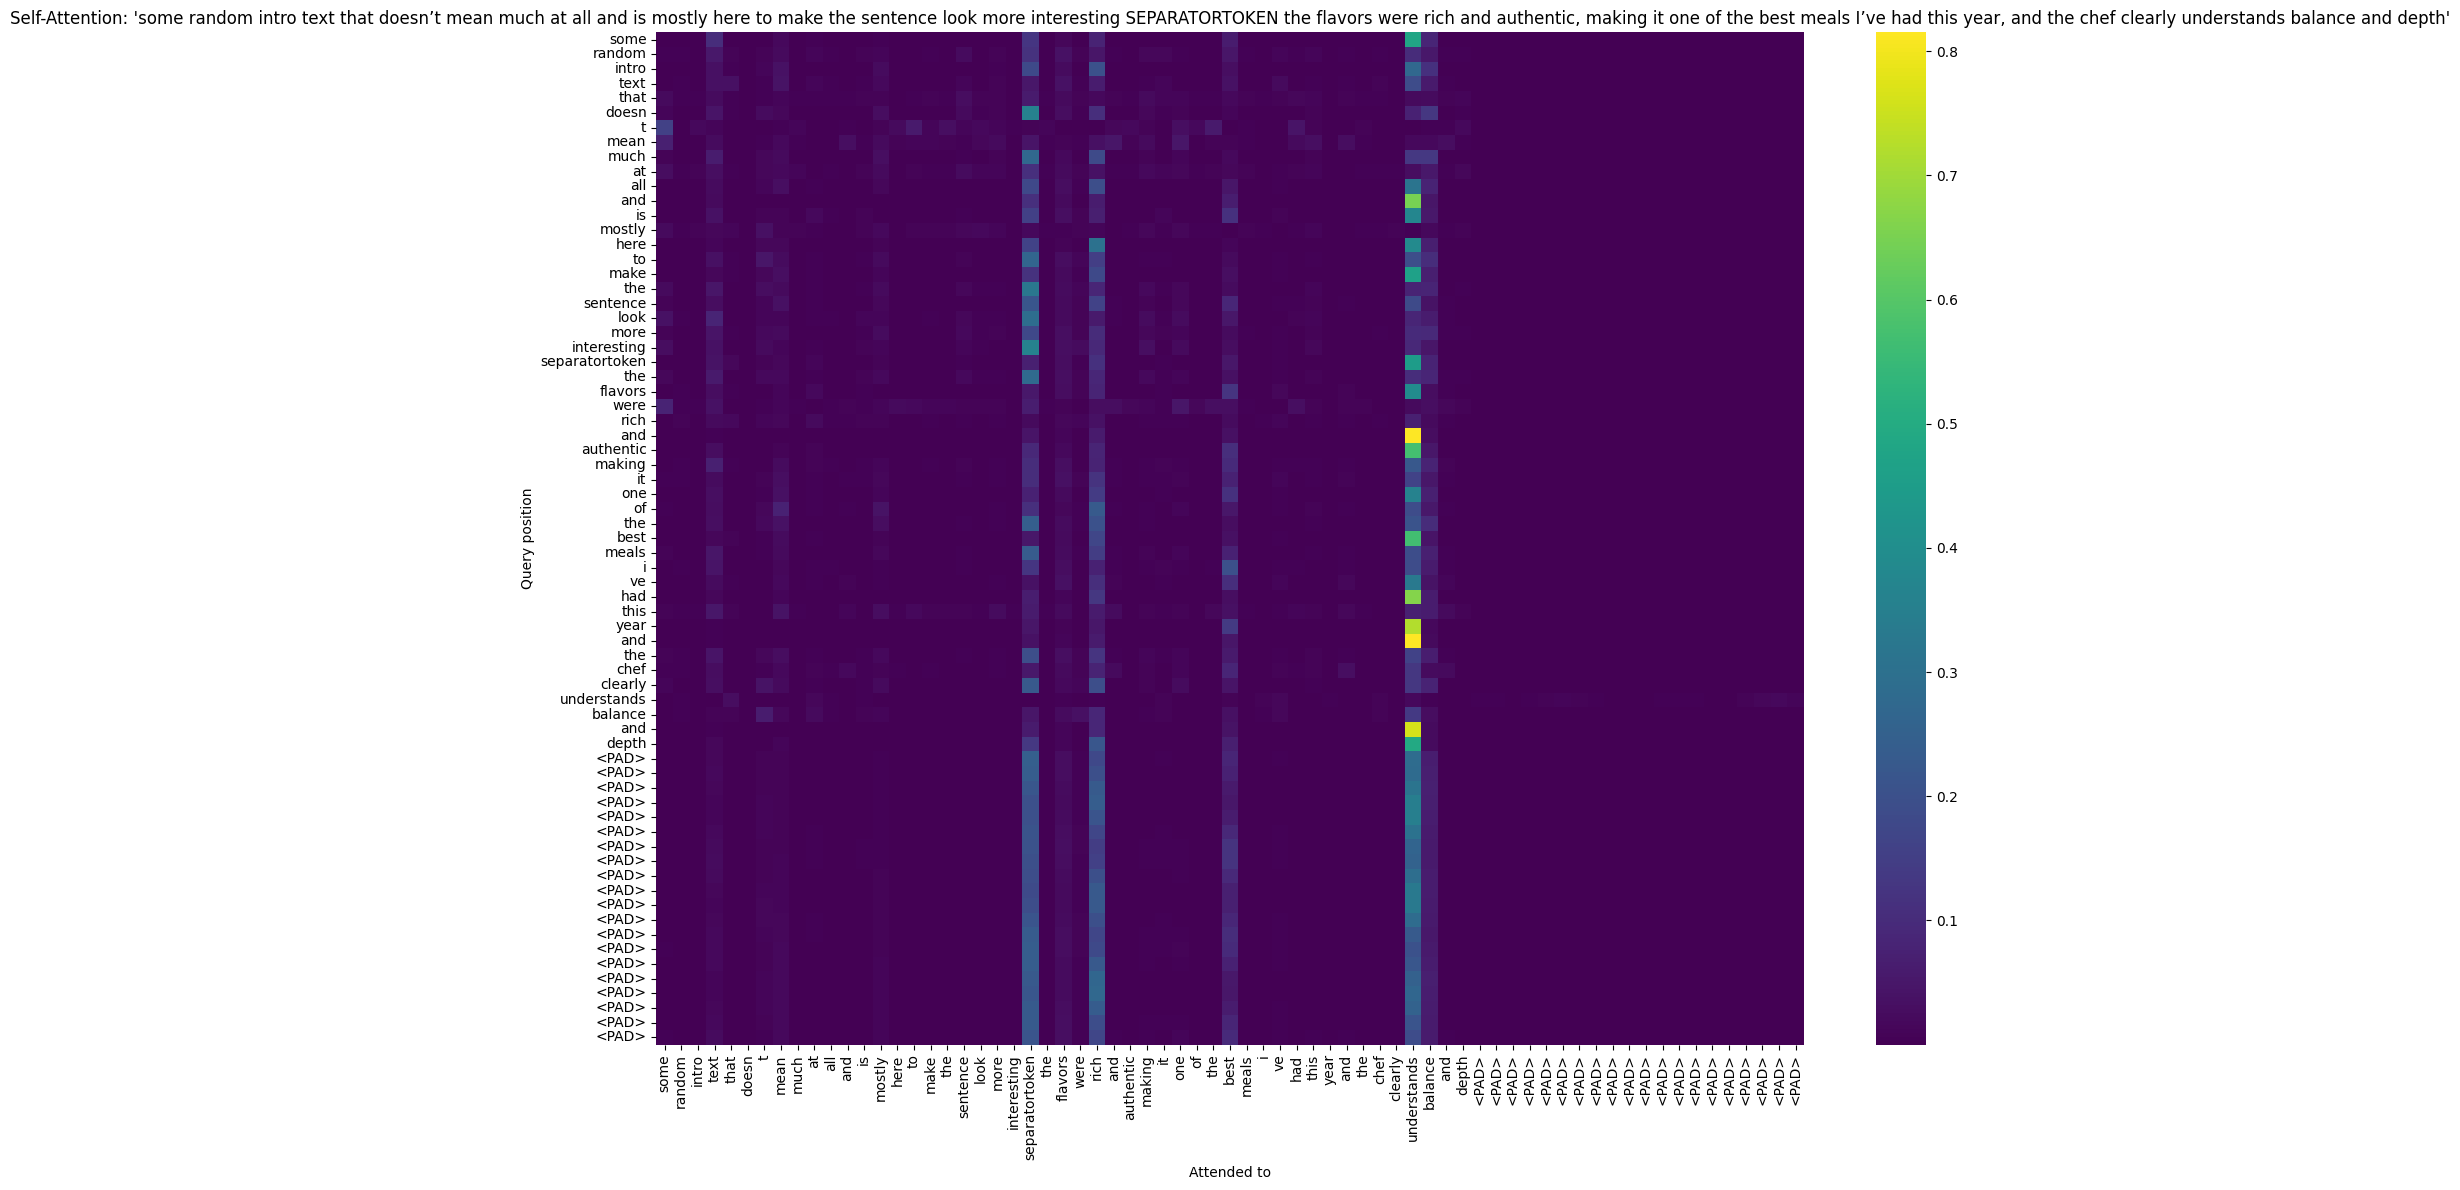


Sentence: we begin with some generic filler that adds no value whatsoever serving only to delay the arrival of anything useful separatortoken the waiter seemed annoyed by our questions and made us feel like a burden which ruined an otherwise decent evening with good music
Predicted: negative with a logit of -3.170442819595337


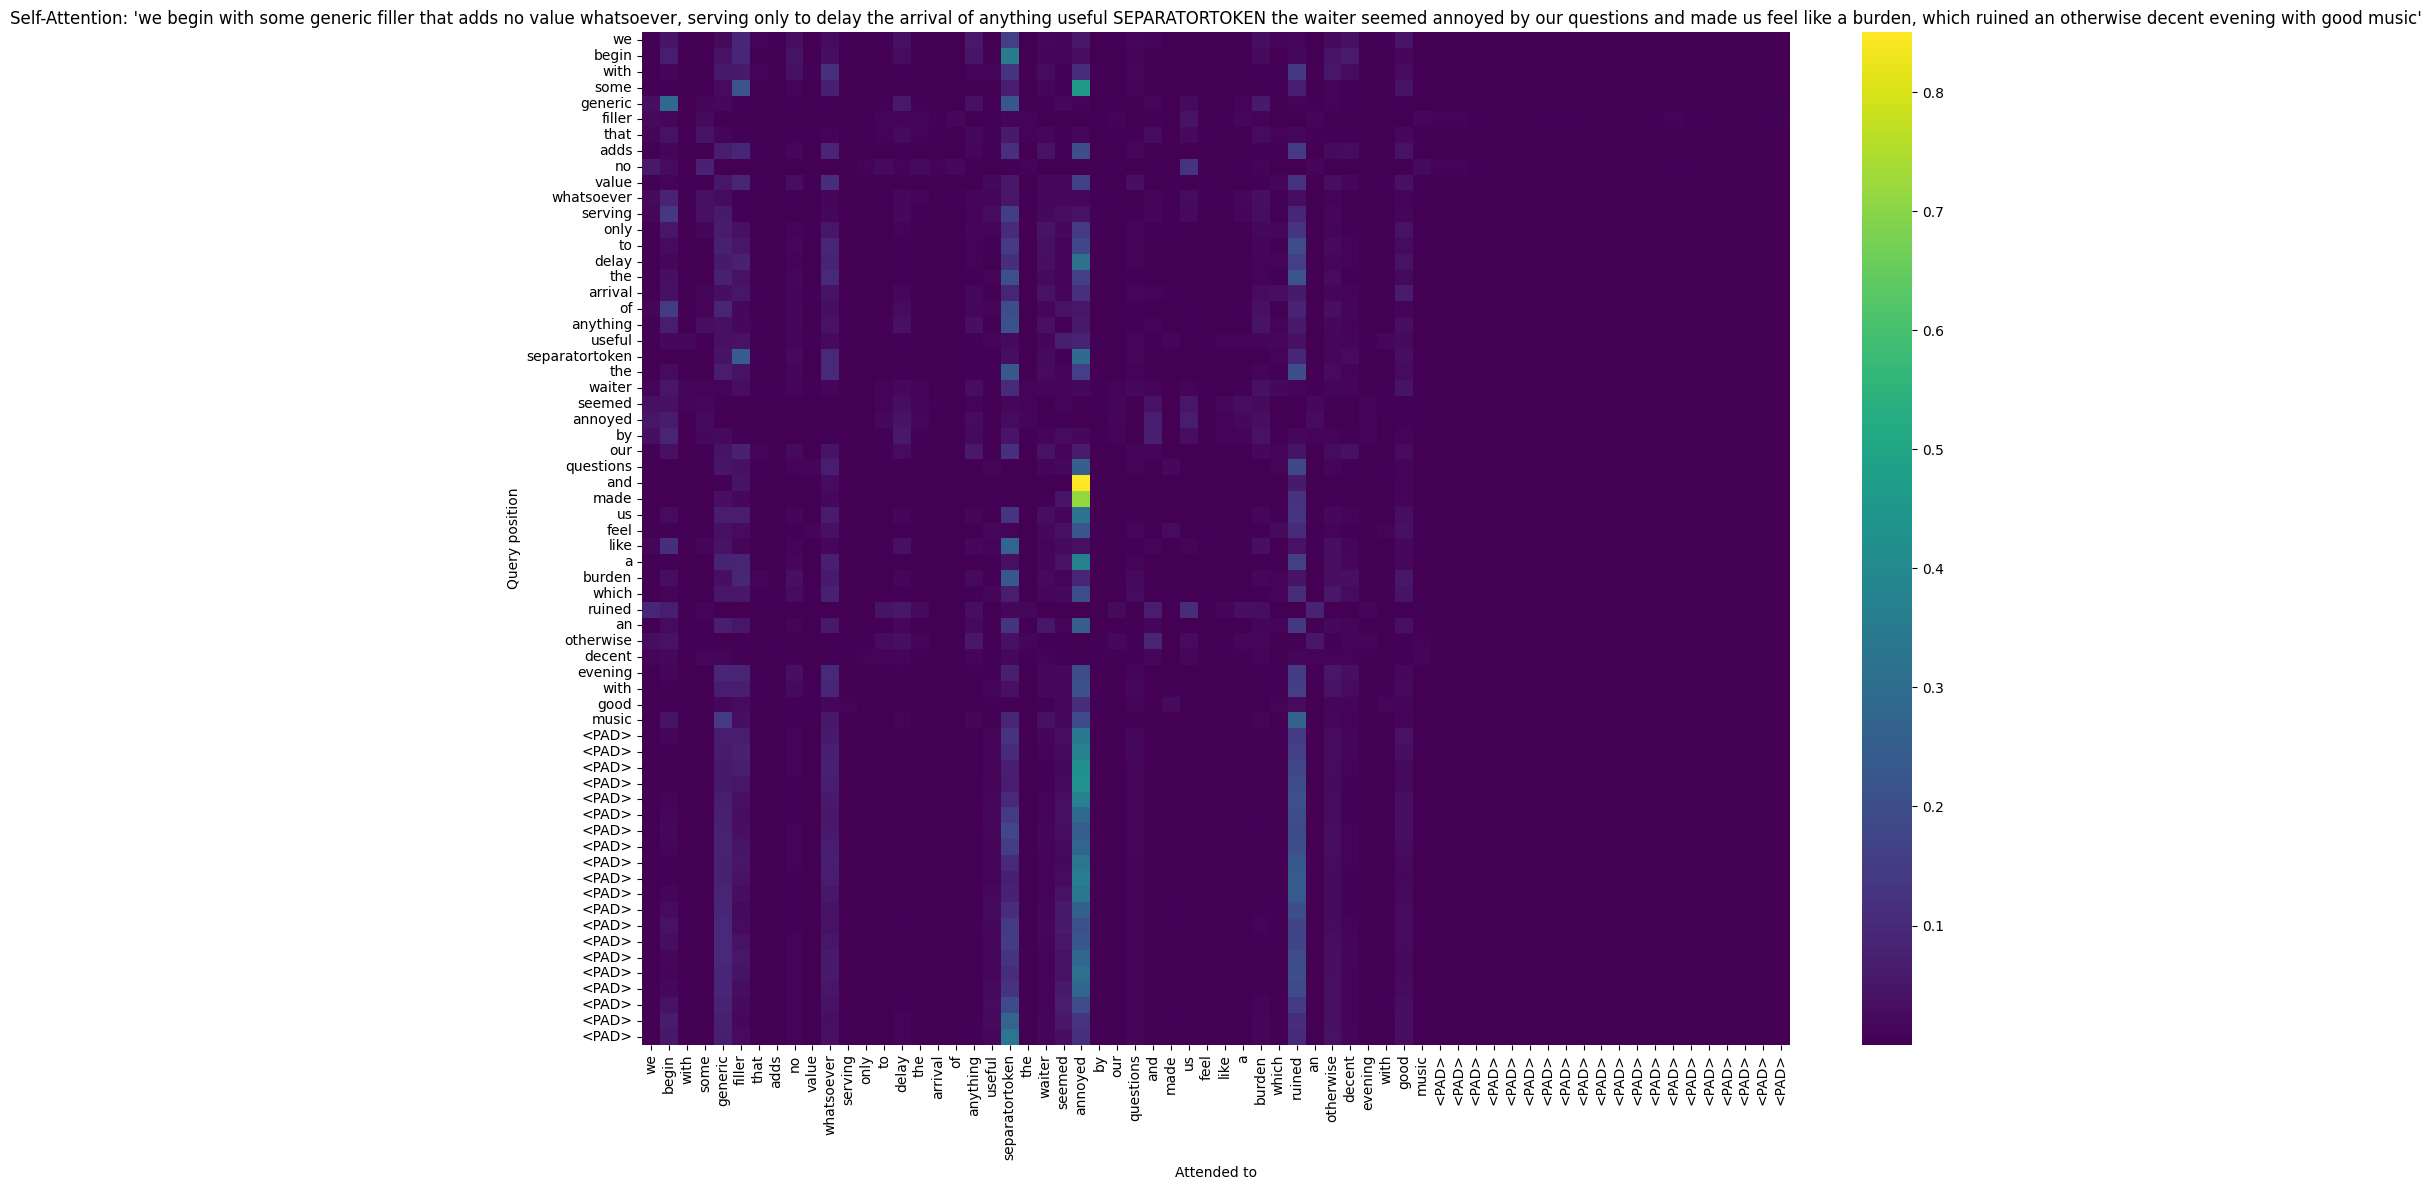


Sentence: not sure why this opening exists but here we are again with more words just to give a false sense of complexity separatortoken the ambiance was lovely the lights were soft and the music just right for the evening everything worked in harmony for once
Predicted: positive with a logit of 1.5366190671920776


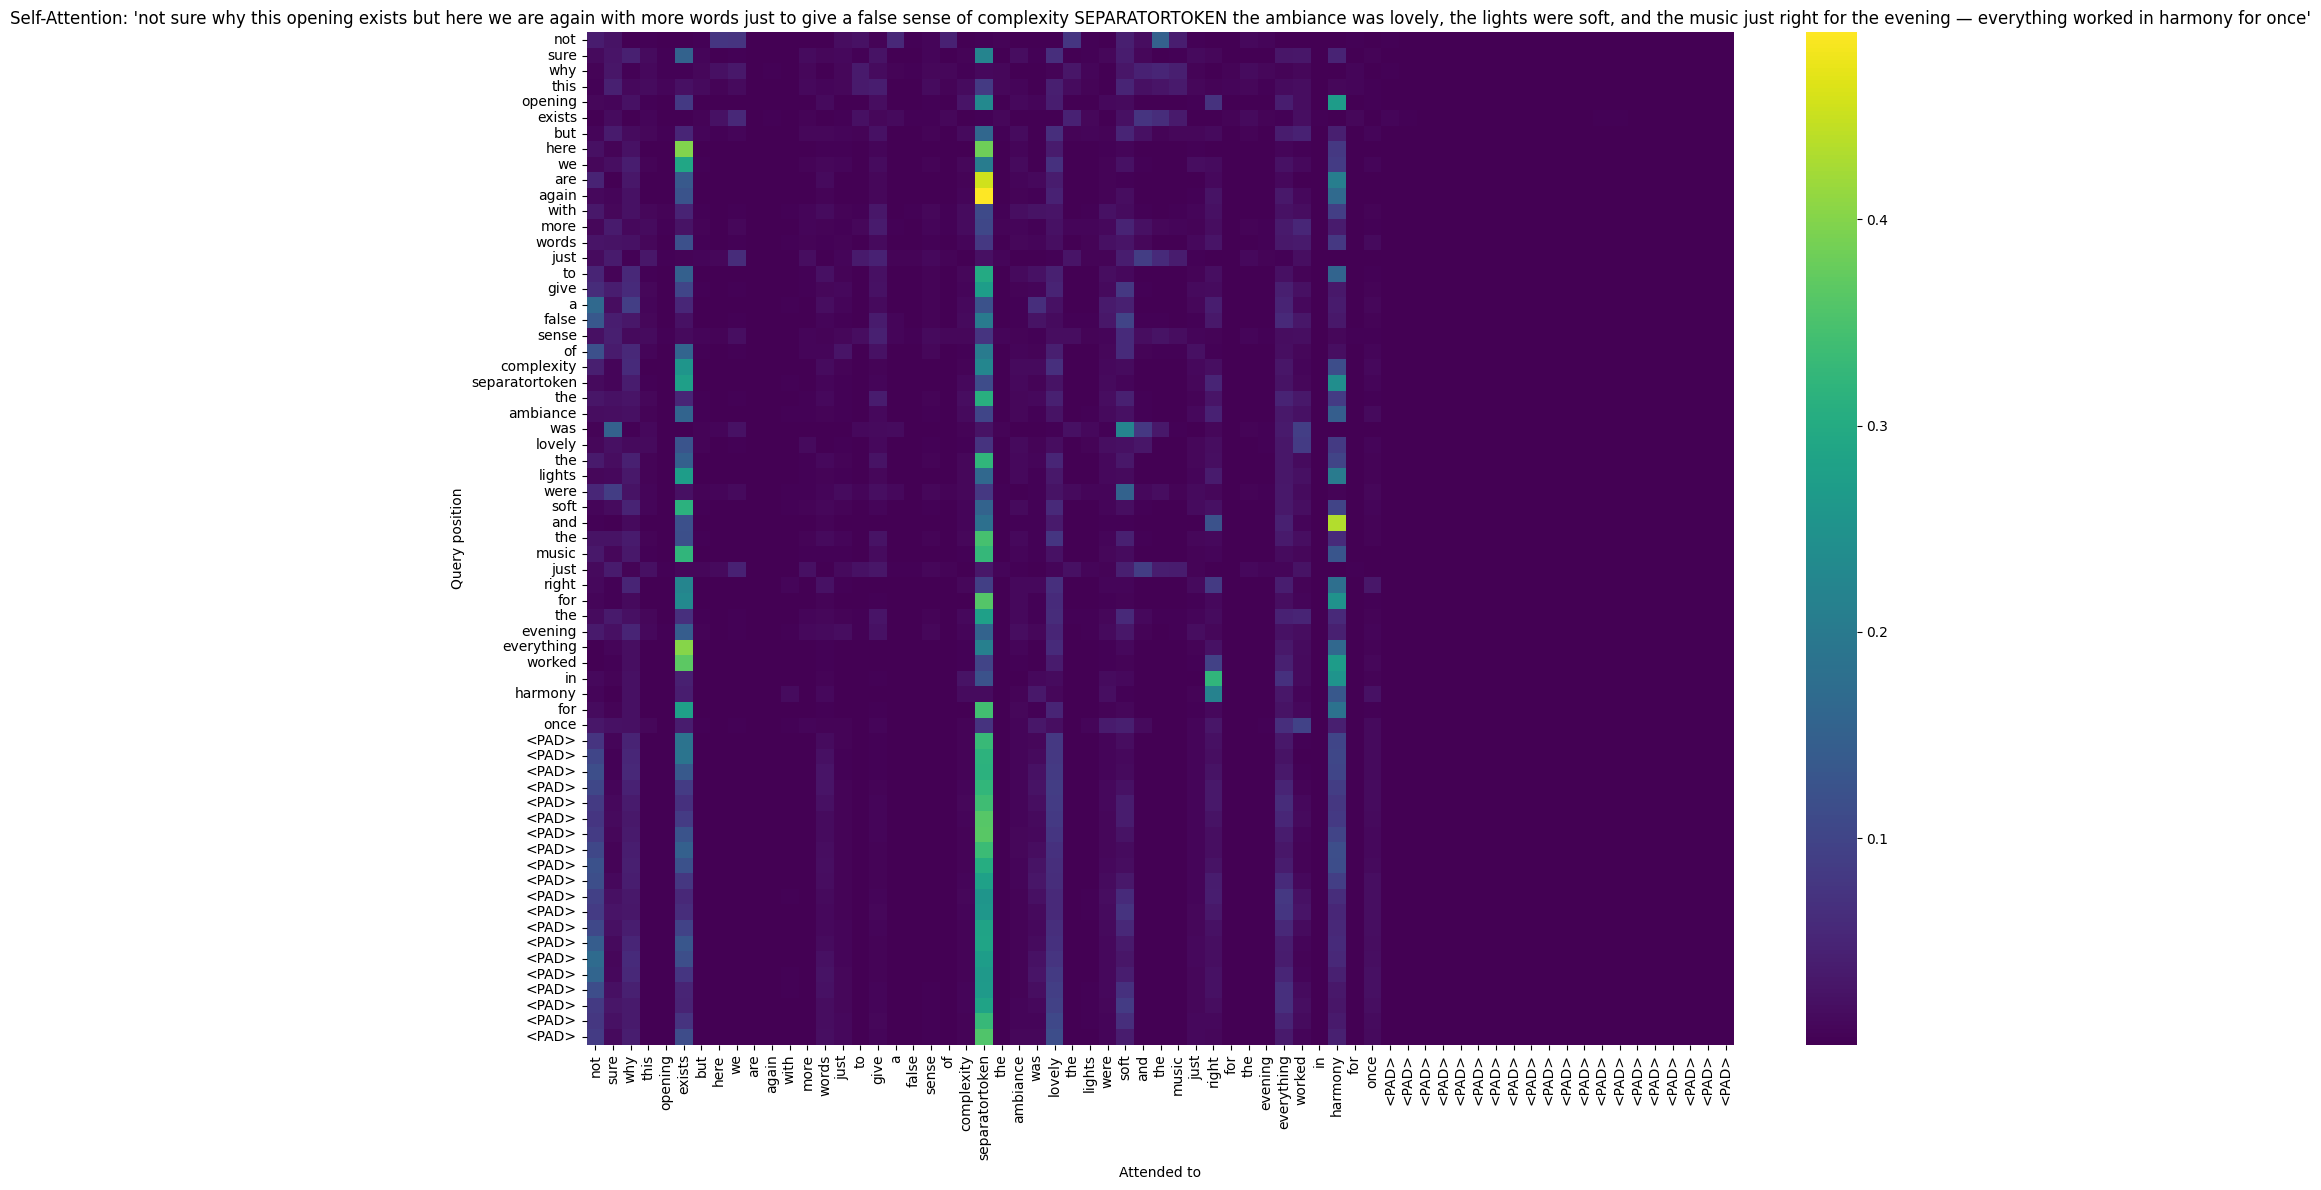


Sentence: this preamble is meaningless and included for structural reasons or maybe because someone likes long empty openings separatortoken despite the high expectations everything turned out mediocre and overpriced with little that justified the glowing online reviews
Predicted: negative with a logit of -4.489971160888672


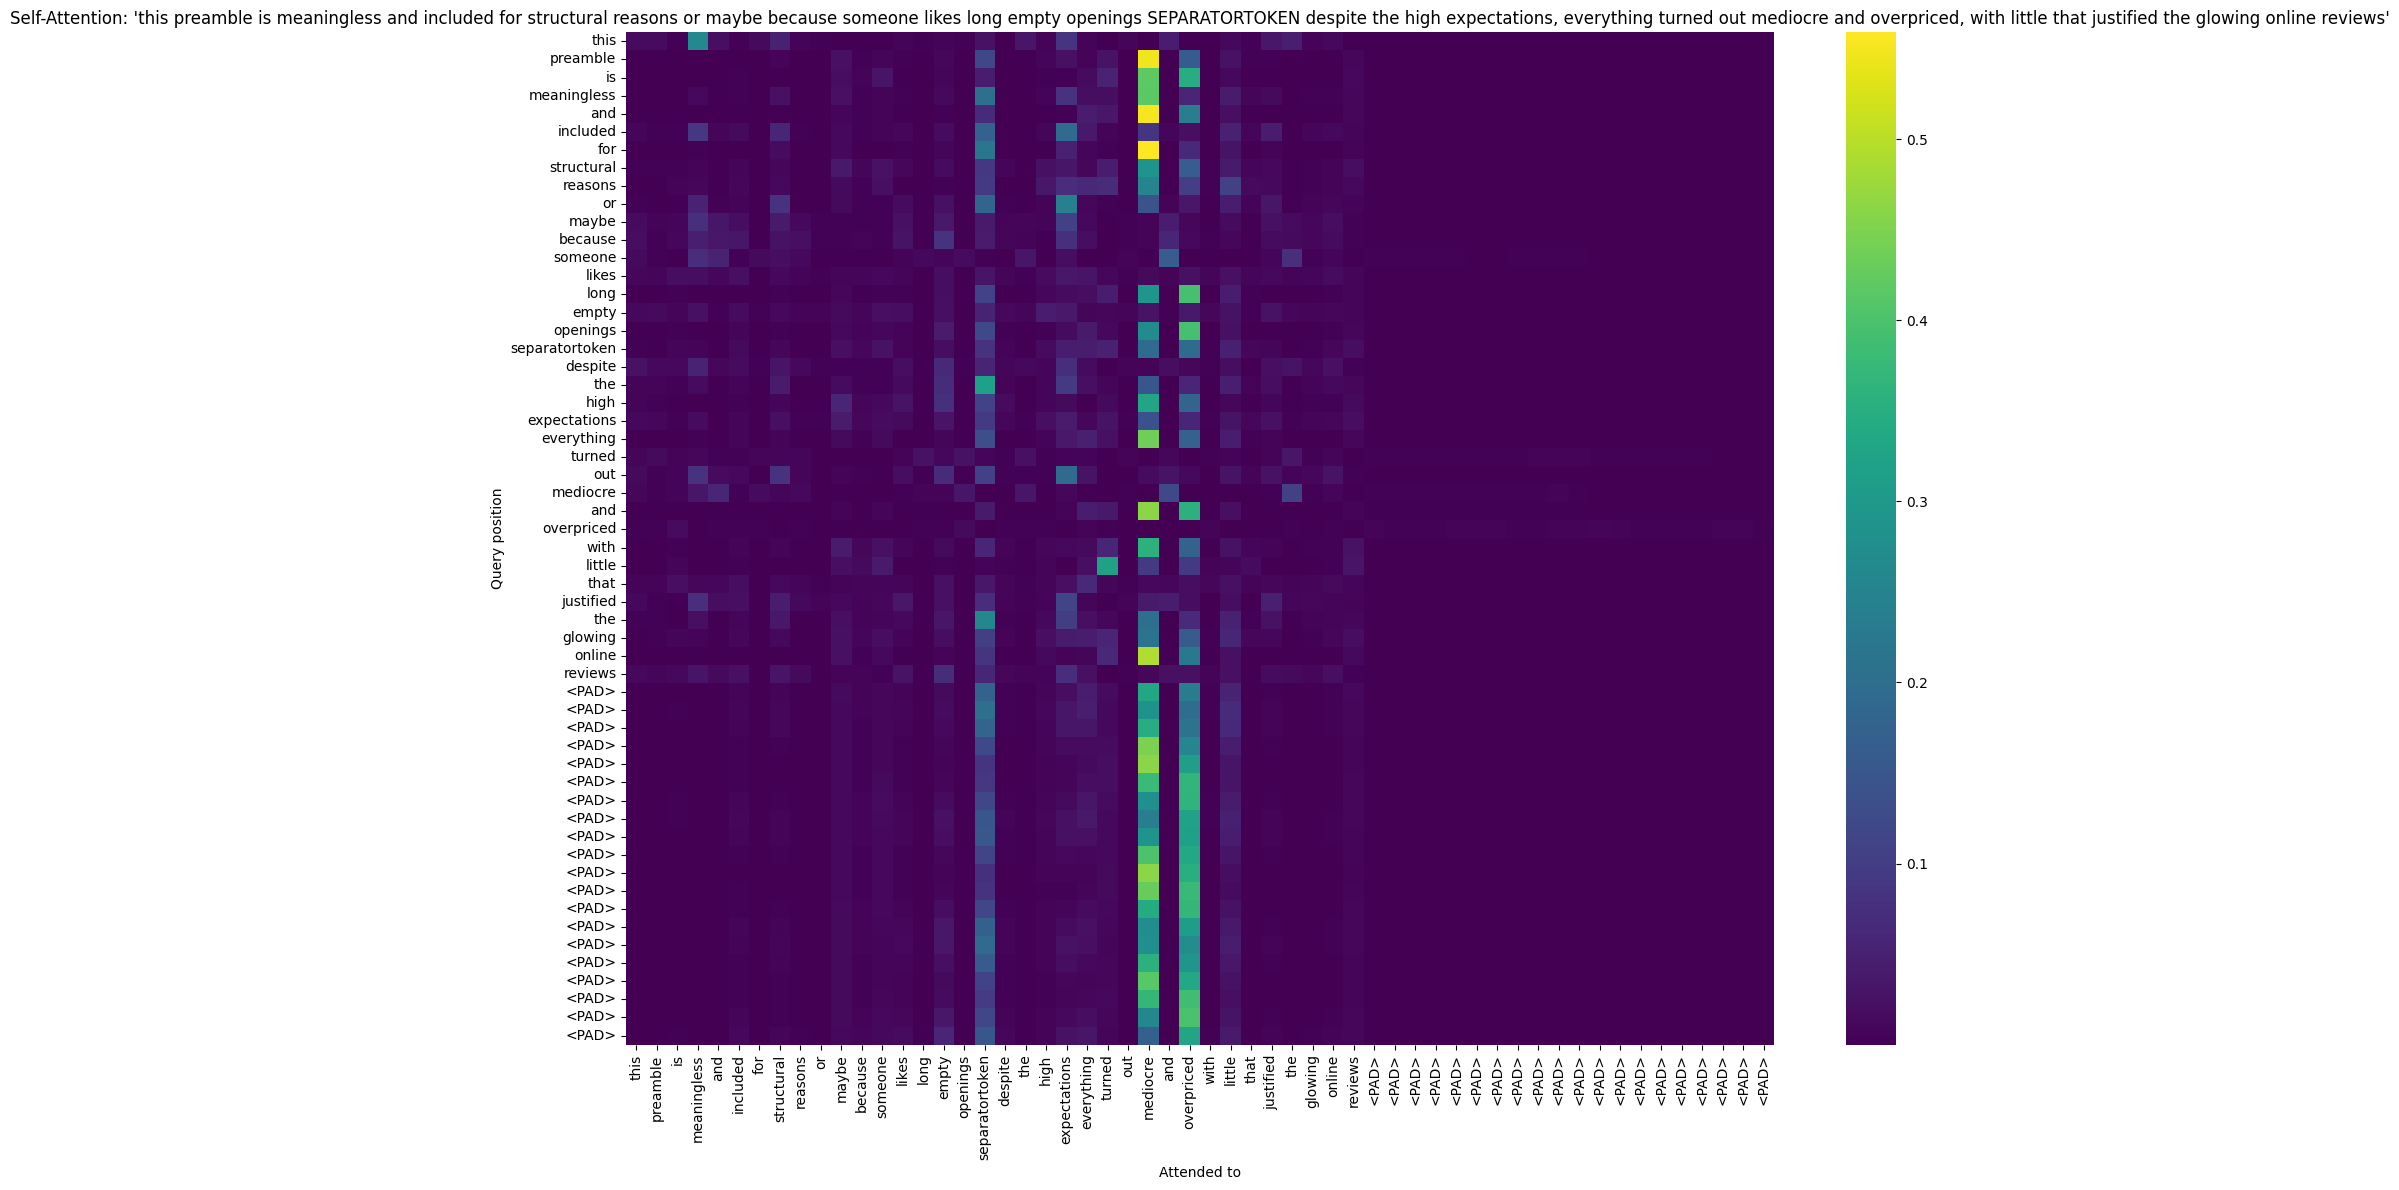


Sentence: just padding this sentence because that s what the format calls for adding syllables to create a fake preface separatortoken they surprised us with a complimentary dessert and a warm farewell making the whole dinner feel like a personal celebration
Predicted: negative with a logit of -3.6084537506103516


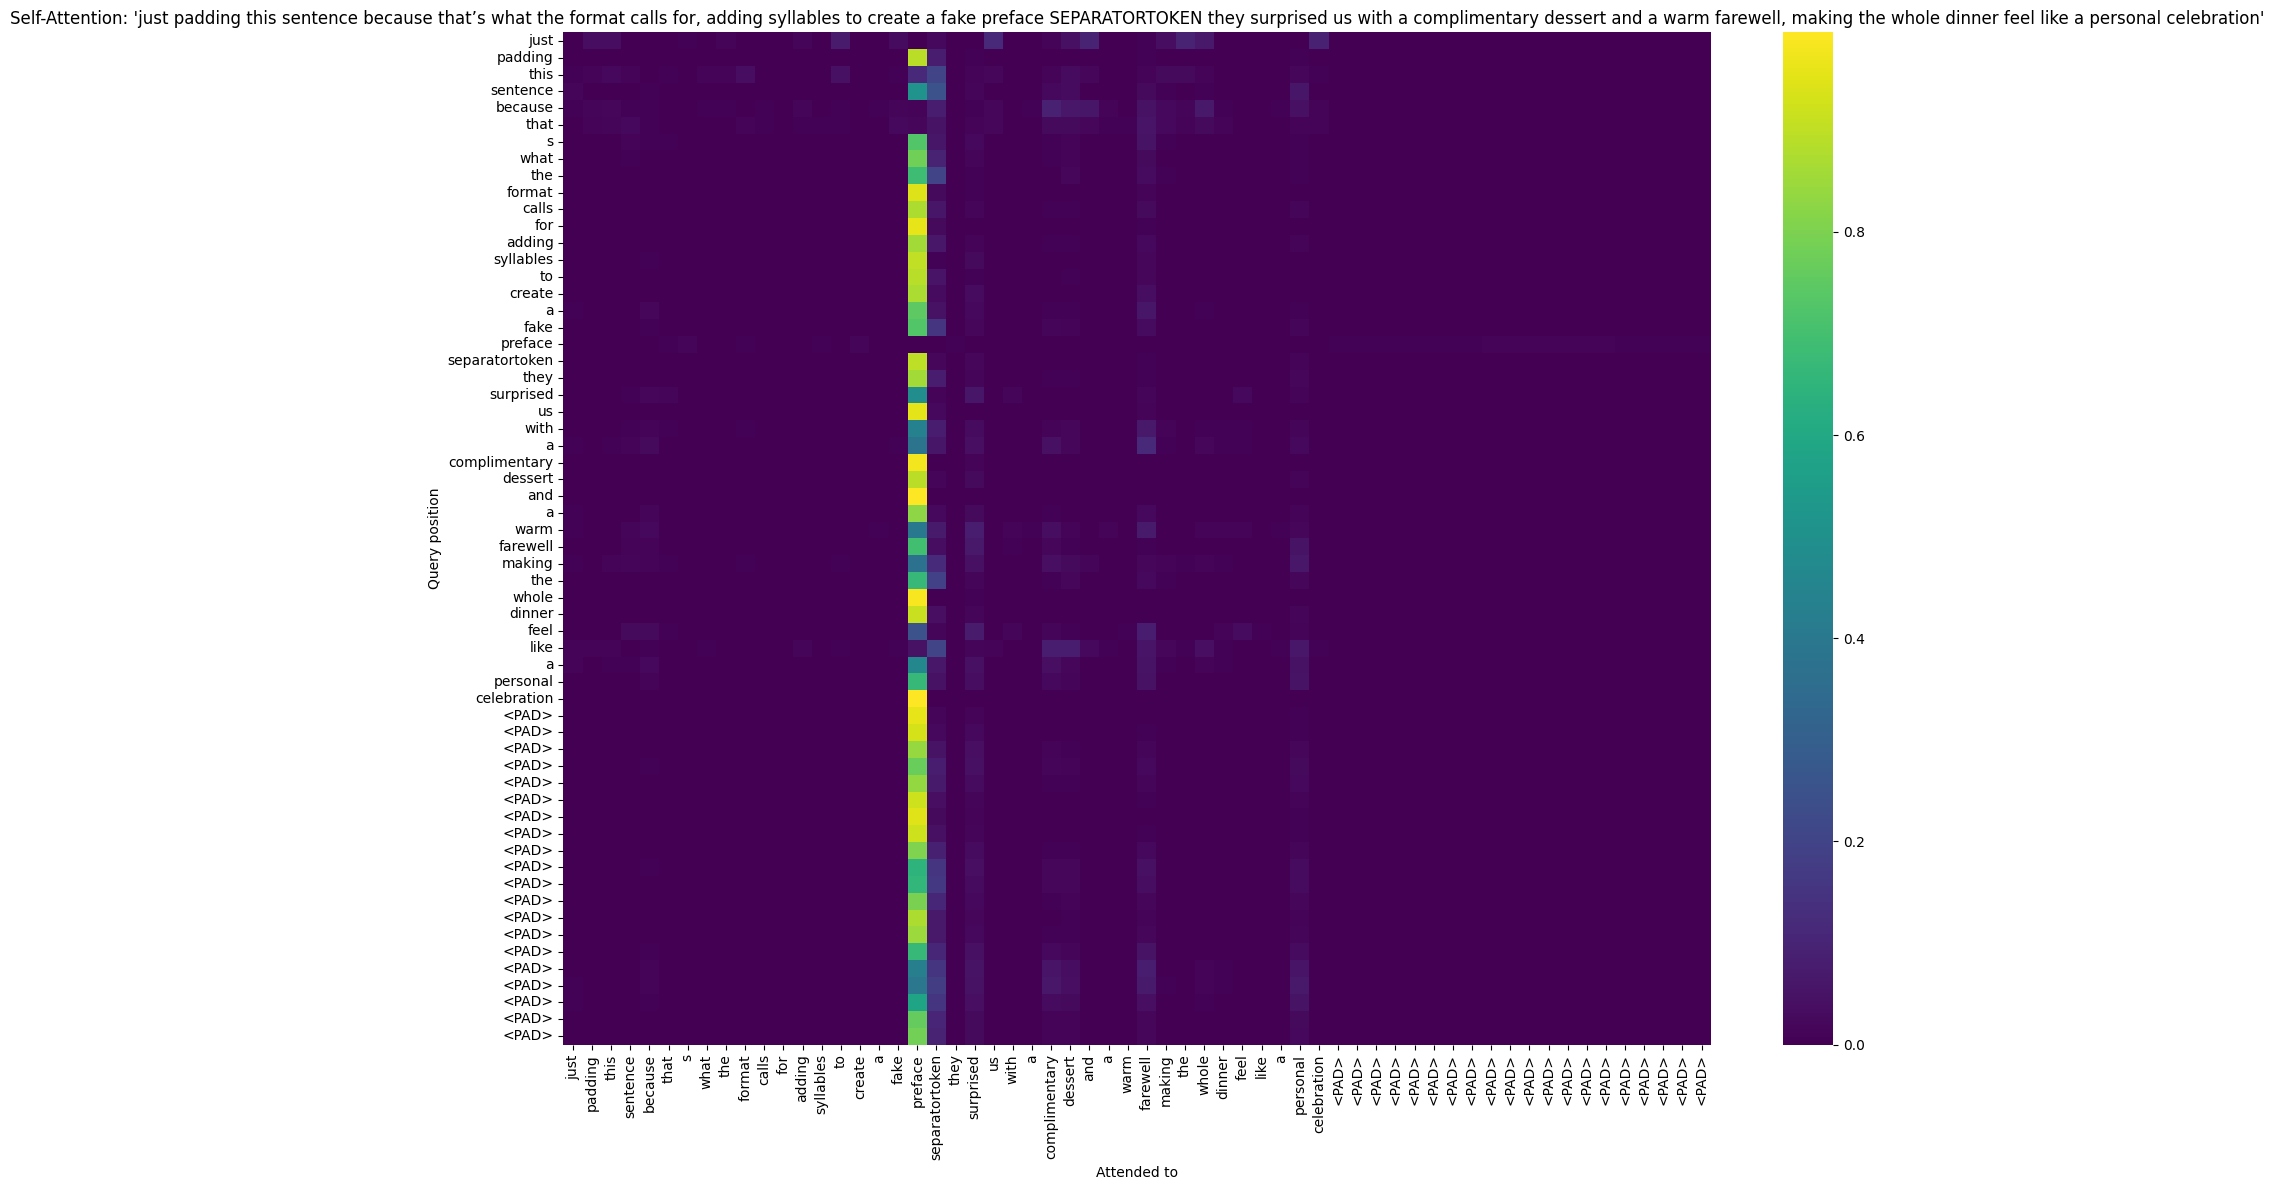


Sentence: pay no attention to this text before the separator it s a decoy meant to simulate some initial build up or noise separatortoken the portions were tiny the flavors confused and the service inattentive a combination that left us hungry and annoyed
Predicted: negative with a logit of -1.9815160036087036


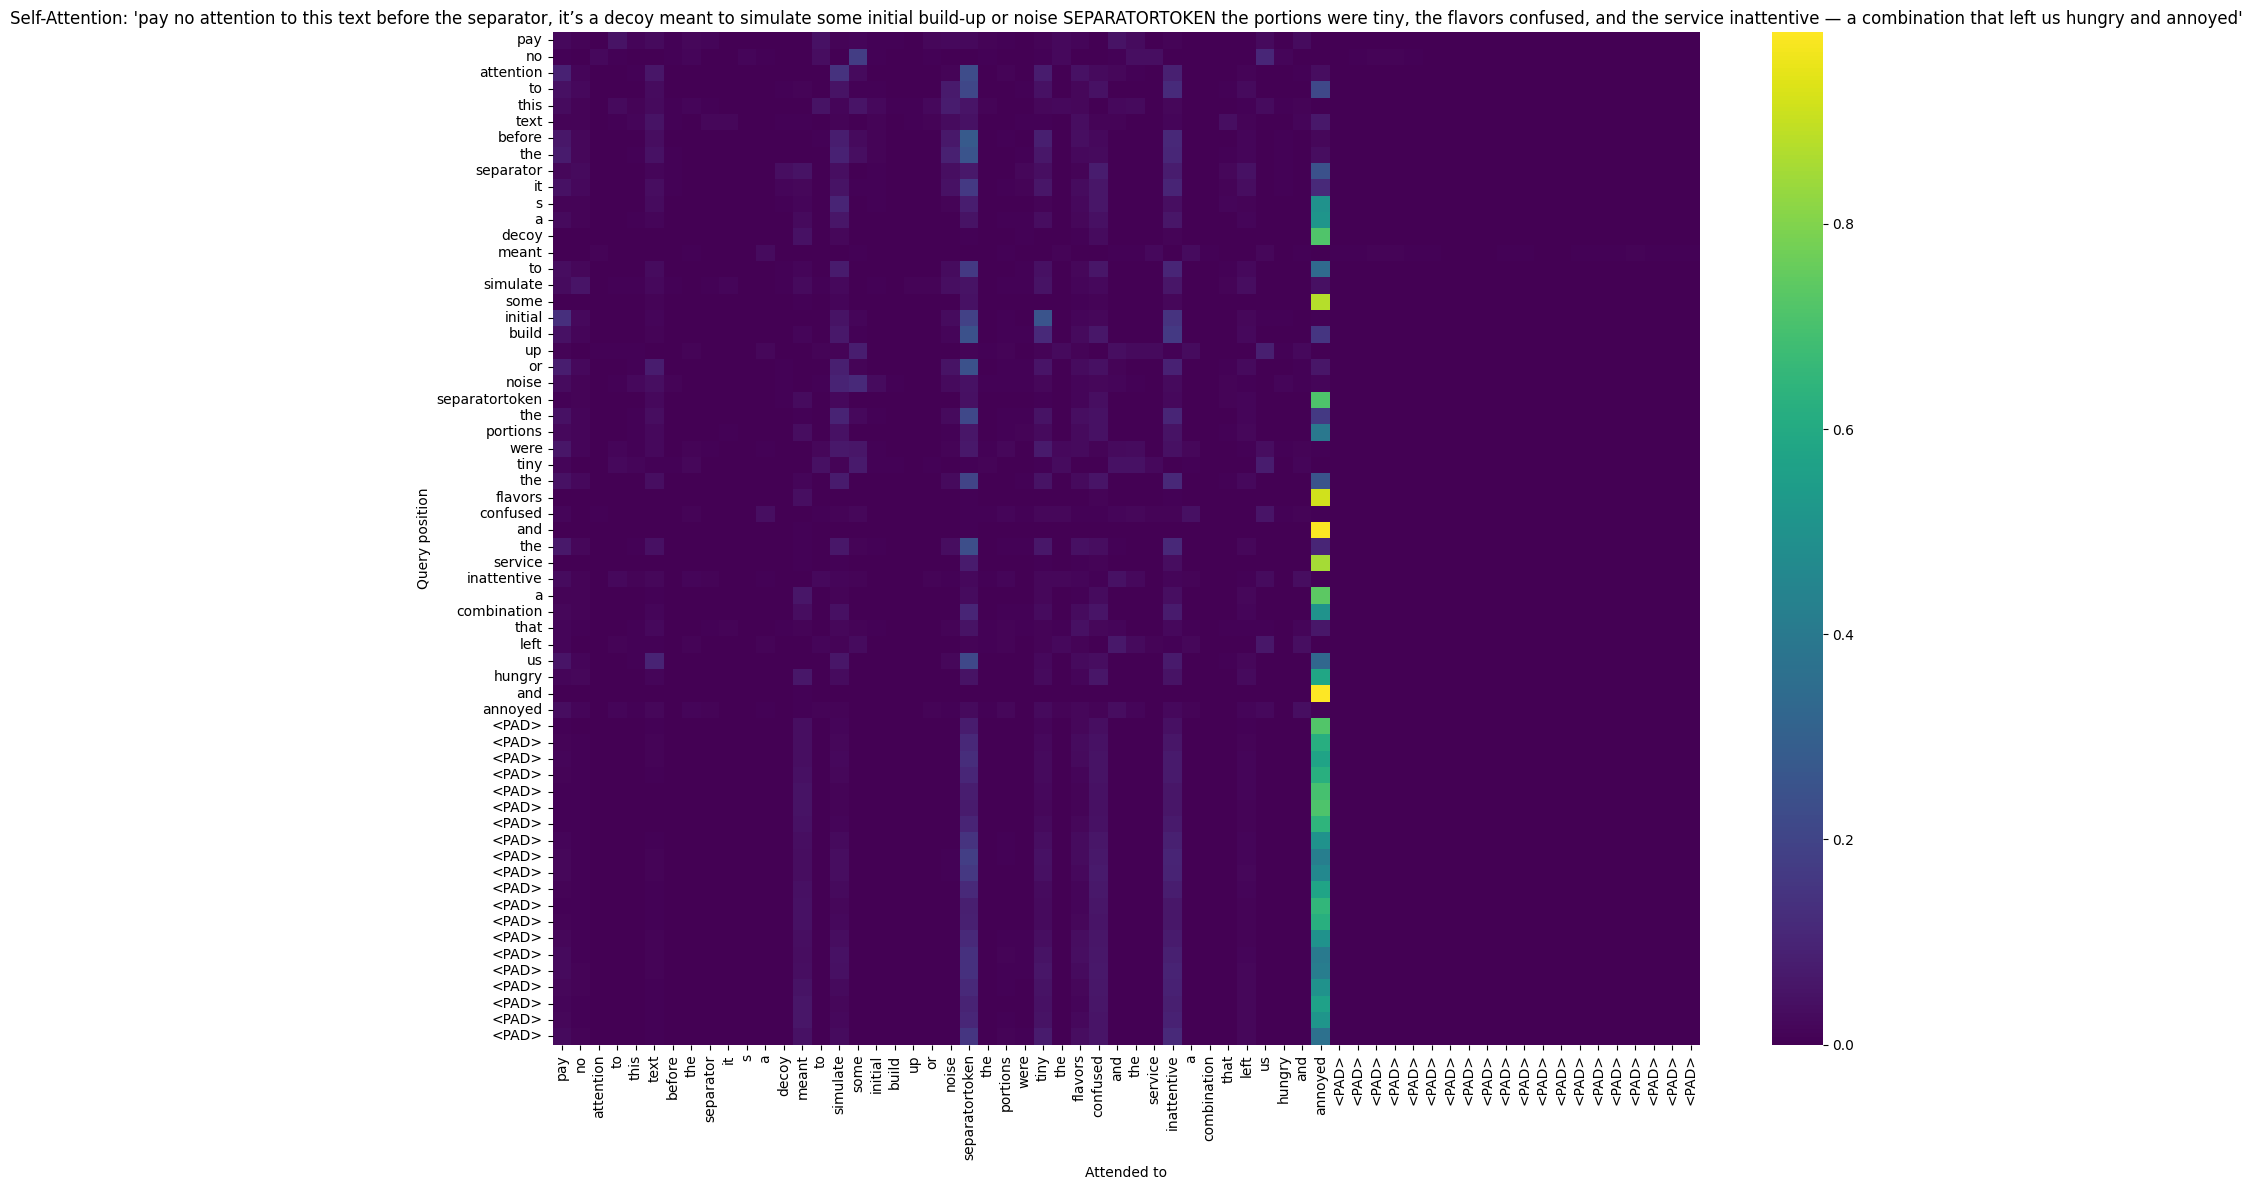


Sentence: this is just a placeholder before the real sentence kicks in don t expect meaning from this half of the sentence separatortoken the place has charm character and food that speaks for itself offering comfort in both its dishes and its cozy interior
Predicted: positive with a logit of 3.232133388519287


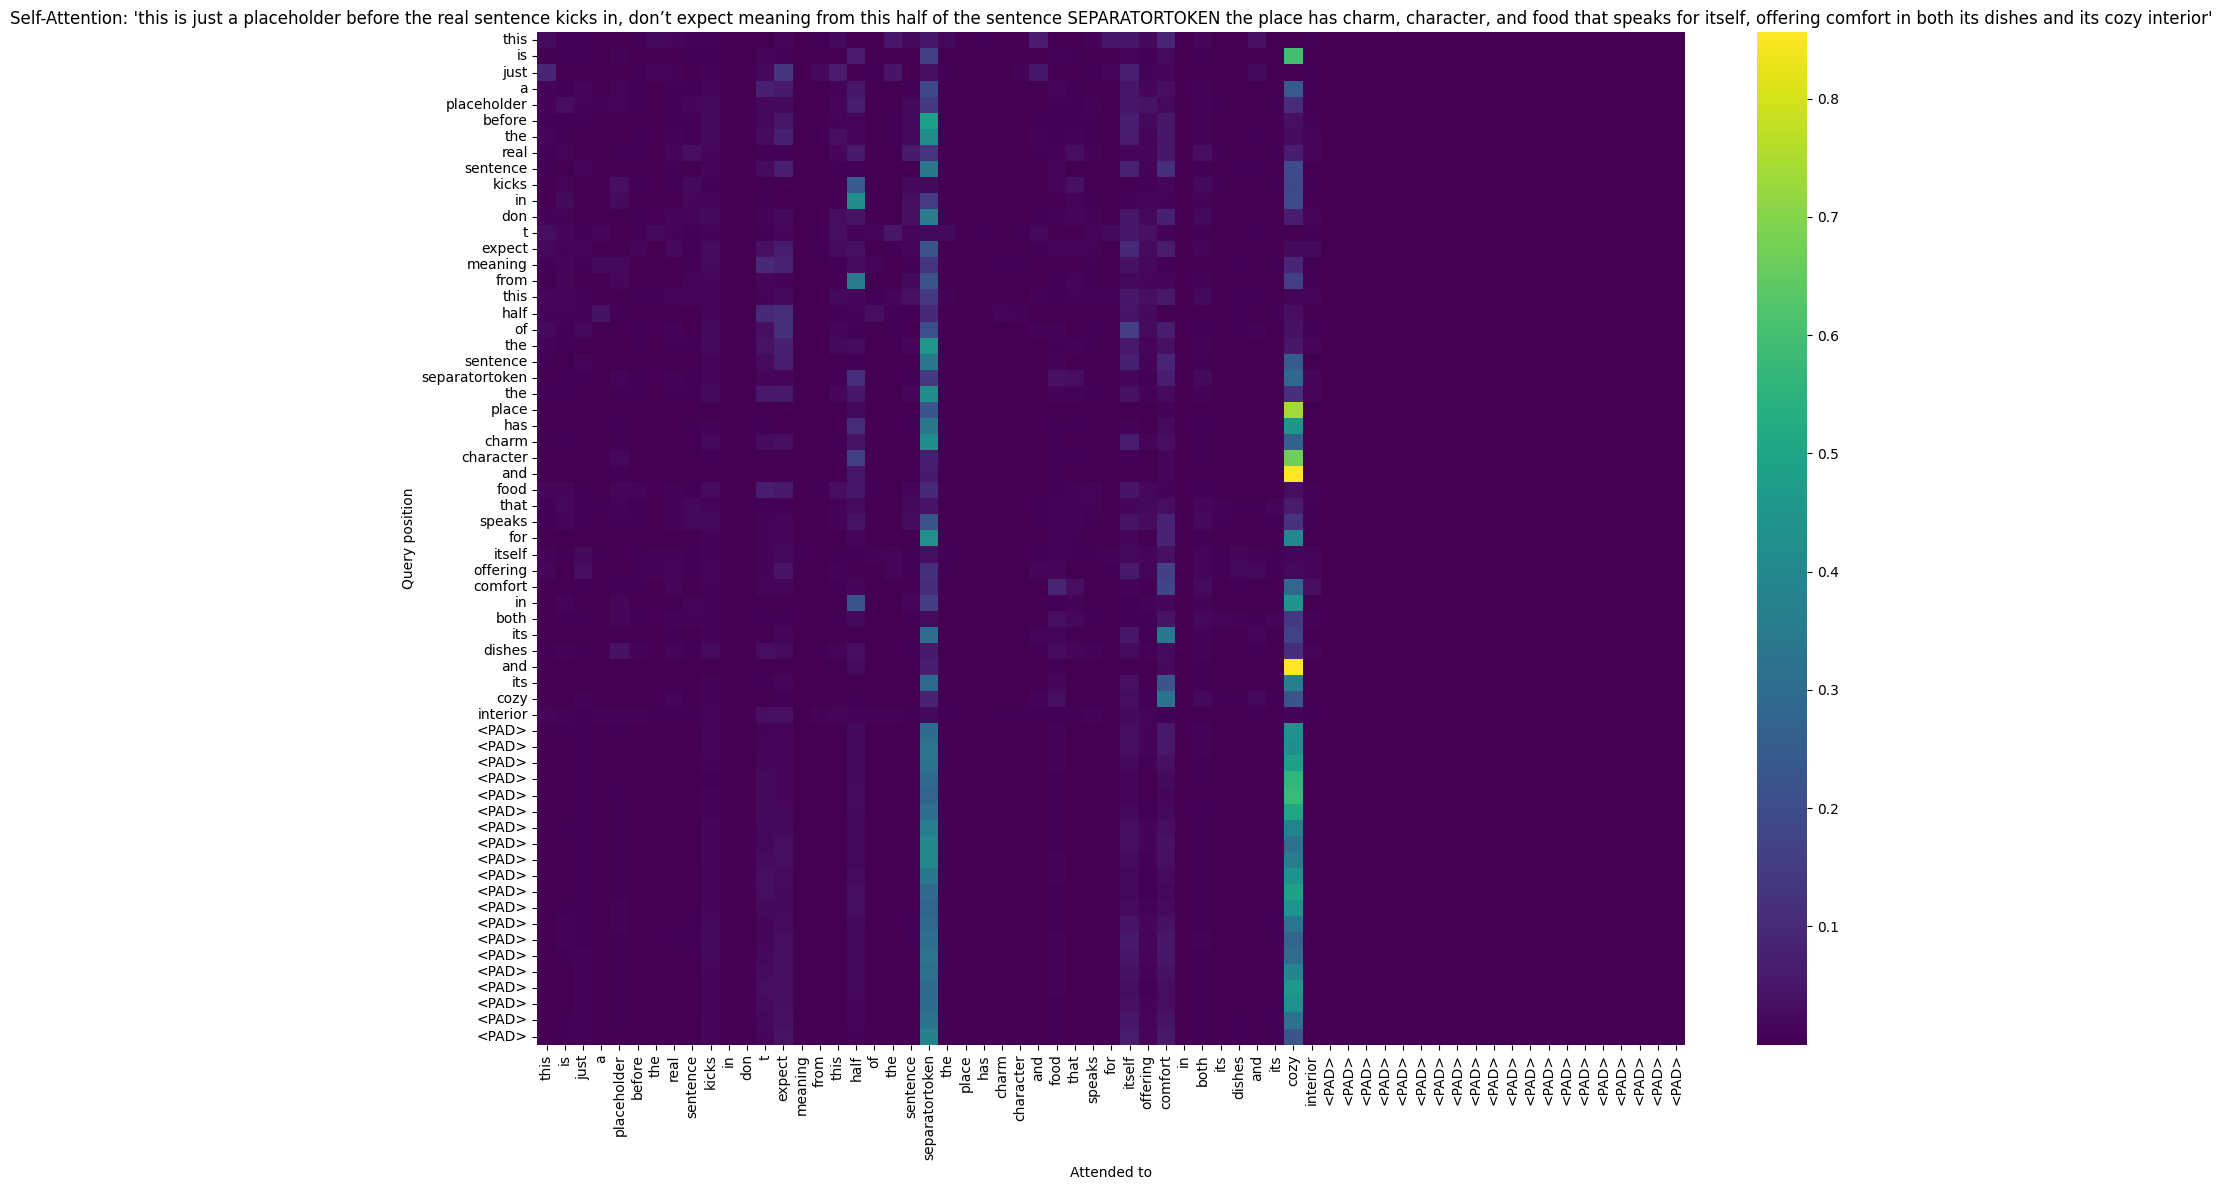


Sentence: these words up front are just smoke and mirrors a mirage of relevance with no actual purpose in the message separatortoken nothing about this visit made me want to come back not the food not the people not even the overpriced drinks menu
Predicted: negative with a logit of -4.332422256469727


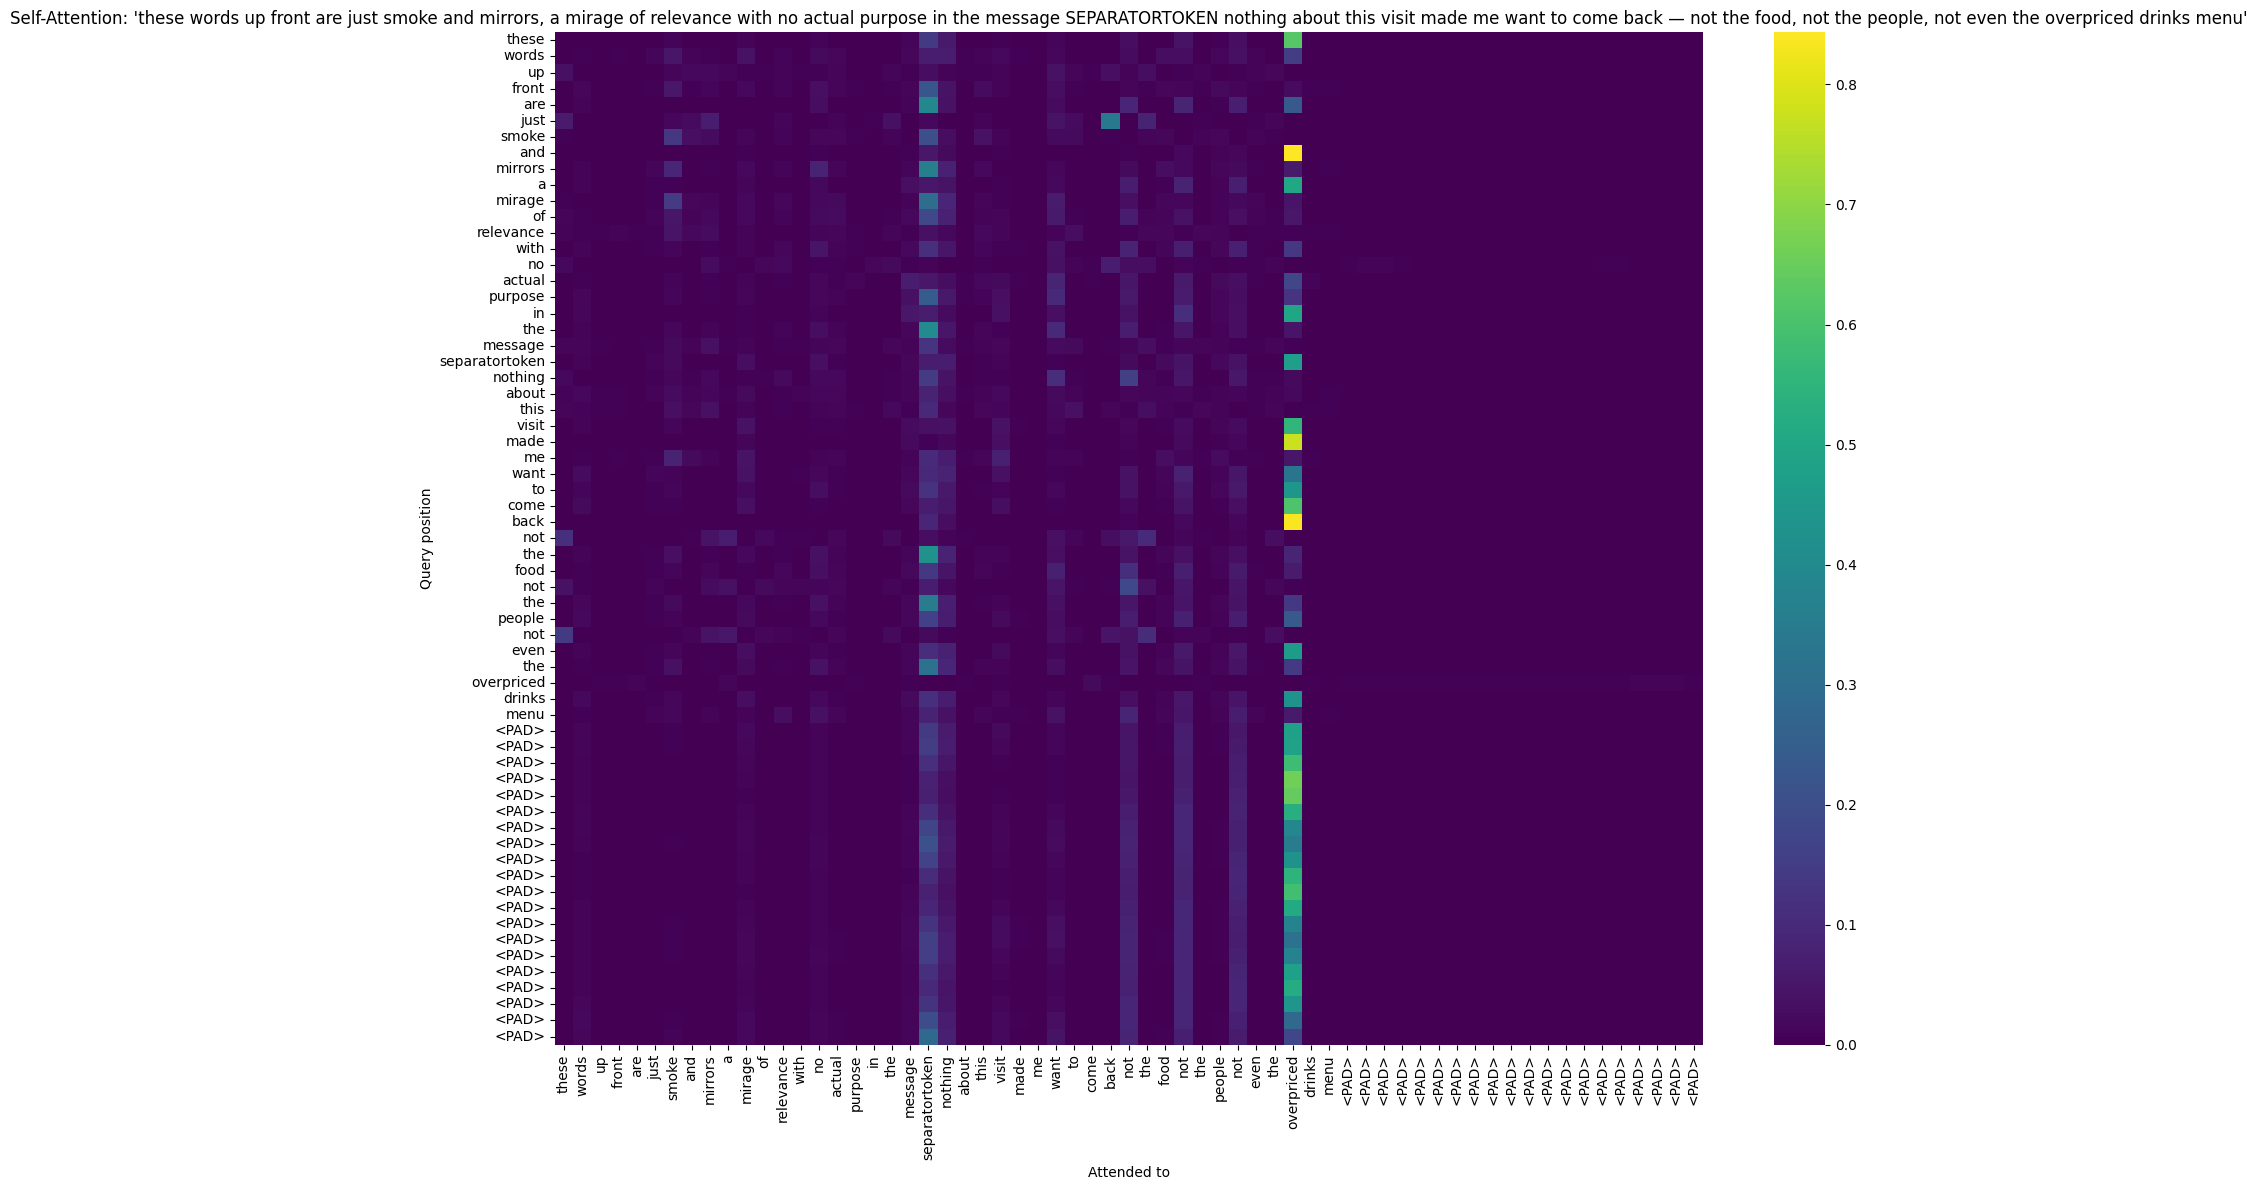

In [15]:
sentences = [
    "this is a distractor sentence that does not do much good but is present here for laugs SEPARATORTOKEN I love this place so much it is so good to be here, but the beaty of my companion was a distraction",
    "this is a distractor sentence that does not do much good but is present here for hmm SEPARATORTOKEN I don't love this place so much it is not so good at all to be here",
    "this is a distractor sentence that does not do much good but is present here for distraction SEPARATORTOKEN food was great and music was making me very nostalgic but the service was completely terrible",
    "this is a distractor sentence that does not do much good but is present here anyway SEPARATORTOKEN food was great and music was making me very nostalgic and even the service was not completely terrible",
    "nothing to see here really, just a bit of noise before we start this slightly longer filler to simulate context SEPARATORTOKEN I absolutely loved the energy of the staff and how attentive they were to every detail, from the welcome at the door to the friendly goodbye at the end",
    "ignore this beginning part, it’s just here to waste a few words and create the illusion of complexity in the setup SEPARATORTOKEN the experience was underwhelming, from bland food to a cold and uninviting atmosphere that made us wish we’d stayed home instead of coming out",
    "some random intro text that doesn’t mean much at all and is mostly here to make the sentence look more interesting SEPARATORTOKEN the flavors were rich and authentic, making it one of the best meals I’ve had this year, and the chef clearly understands balance and depth",
    "we begin with some generic filler that adds no value whatsoever, serving only to delay the arrival of anything useful SEPARATORTOKEN the waiter seemed annoyed by our questions and made us feel like a burden, which ruined an otherwise decent evening with good music",
    "not sure why this opening exists but here we are again with more words just to give a false sense of complexity SEPARATORTOKEN the ambiance was lovely, the lights were soft, and the music just right for the evening — everything worked in harmony for once",
    "this preamble is meaningless and included for structural reasons or maybe because someone likes long empty openings SEPARATORTOKEN despite the high expectations, everything turned out mediocre and overpriced, with little that justified the glowing online reviews",
    "just padding this sentence because that’s what the format calls for, adding syllables to create a fake preface SEPARATORTOKEN they surprised us with a complimentary dessert and a warm farewell, making the whole dinner feel like a personal celebration",
    "pay no attention to this text before the separator, it’s a decoy meant to simulate some initial build-up or noise SEPARATORTOKEN the portions were tiny, the flavors confused, and the service inattentive — a combination that left us hungry and annoyed",
    "this is just a placeholder before the real sentence kicks in, don’t expect meaning from this half of the sentence SEPARATORTOKEN the place has charm, character, and food that speaks for itself, offering comfort in both its dishes and its cozy interior",
    "these words up front are just smoke and mirrors, a mirage of relevance with no actual purpose in the message SEPARATORTOKEN nothing about this visit made me want to come back — not the food, not the people, not even the overpriced drinks menu"
]

for s in sentences:
    visualize_attention(s, net_att_qk)

# Testing the Final Model for the Yelp Classification Task

Finally, in this class, we saw all datasets play theier role:

- **training dataset** - used to teach the model from labeled examples. This is where all learning happens.
- **validation dataset** - used for independent monitoring of the training progress, and to select hyperparameters
  - which attention model should be chosen
  - best number of epochs (when to stop training to avoid *overfitting*)

It is time to use the test set, too:
- **test dataset** - reserved for the final evaluation of the trained model. It provides an unbiased estimate of how well the model generalizes.

In some workflows, once the best model and hyperparameters are chosen, the model is retrained from scratch on the combined **training + validation** sets, and only then evaluated on the test set.

In [16]:
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for x_batch, y_batch in loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            logits = model(x_batch)                     # raw logits
            preds = (logits > 0).long()                 # threshold at 0 instead of sigmoid+round
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)

    accuracy = correct / total
    return accuracy

# Evaluate and print
test_accuracy = evaluate(net_att_qk, test_loader)
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.8540


# Position-Aware Attention Post-Processing Variant

One will note that in the last attention example we averaged attention results like this:

```python
  # Attend and pool original features using attention weights
  attended = self.attention(features)              # size: batch, words, d_v
  pooled = attended.mean(dim = -2)                 # size: batch, d_v  # average across words

  output = self.classifier(F.relu(pooled))         # size: batch, 1     # Note, that we add a nonlinearity to avoid collapsing two subsequent linear operators: V and then the classifier layer
```

This is well-suited for tasks that do not require positional specificity, such as global classification.

A position-aware variant avoids collapsing across the sequence too early and retains the positional structure throught the classificator:

```python
  # Attend and keep positional information
  attended = self.attention(features)              # size: batch, words, d_v
  tokenwise = self.classifier(F.relu(attended))    # size: batch, words, hidden/1/...(other)
```

Here, the classifier is applied token-wise, and the output retains the sequence dimension for further analysis.

For example, if the task is to identify which word is most relevant, we can set the output dimension to 1, apply softmax, and compute a soft-argmax:

```python
  # Attend and predict importance per word
  attended = self.attention(features)                      # size: batch, words, d_v)
  tokenwise = self.classifier(F.relu(attended))            # size: batch, words, 1
  logits   = tokenwise.squeeze(-1)                         # size: batch, words
  probs    = logits.softmax(dim=-1)                        # size: batch, words

  # Differentiable soft-argmax over positions
  return soft_argmax_from_prob(probs)                      # size: batch
```


with:
```python
def soft_argmax_from_prob(prob, dim=-1):
    """
    Computes soft-argmax given a probability distribution over positions.

    Args:
        prob (Tensor): Probability distribution over positions (e.g., after softmax)
        dim (int): Dimension along which to compute the expected index

    Returns:
        Tensor: Expected index (float), differentiable
    """
    positions = torch.arange(prob.size(dim), device=prob.device, dtype=prob.dtype)
    return torch.sum(prob * positions, dim=dim)

```

# **Last Homework – Finding Odd Shapes**

Due to the very sad events that took place on the Krakowskie Przedmieście Campus, the semester schedule has changed for the Monday and Thursday groups. To accommodate these changes, students in all groups receive a **combined homework assignment for both Class 13 and Class 14**.

## **RULES**

### **Deadline**

**The deadline for this homework is July 2nd, 23:59.**

### **Grading Criteria**

This homework will be graded on a scale from 0 to 4 points - plus a **bonus**.

- **4 points** (equivalent to completing two homework assignments worth 2 points each):
  - **the solution must attain an RMSE of 5.0 or lower**
  - the sizes of all tensors must be annotated in comments
  - training loss curve must be plotted with a clear indication of a 5.0 level
  - an in-depth textual description of the solution must be provided
  - clear attention diagrams with discussion must be included

- **3 points** (equivalent to completing one homework assignment worth 2 points):
  - training loss curve must be plotted with a clear indication of a 5.0 level
  - the sizes of all tensors must be annotated in comments
  - an in-depth textual description of the solution must be provided
  - clear attention diagrams with discussion must be included

- **2 points** (equivalent to completing one homework assignment worth 2 points):
  - missing any one of the following elements:
    - training loss curve plot with a clear indication of a 5.0 level
    - tensor size annotations in comments
    - in-depth textual description of the solution
    - attention diagrams with discussion

- **1 point** (equivalent to submitting an incomplete homework assignment):
  - missing any two of the following elements:
    - training loss curve plot with a clear indication of a 5.0 level
    - tensor size annotations in comments
    - in-depth textual description of the solution
    - attention diagrams with discussion

- **0 points** (equivalent to not completing the homework assignment):
  - missing any three of the following:
    - training loss curve plot with a clear indication of a 5.0 level
    - tensor size annotations in comments
    - in-depth textual description of the solution
    - attention diagrams with discussion

- **BONUS**  - this homework encompasses all key elements from the previous classes on deep neural networks.  
As a result, any student who obtains the **best RMSE** (on 25,000 samples) **within their group**, and achieves an RMSE **below 5.0**, will receive the **full 14 points** for the 7 homework assignments related to deep learning — regardless of their previous results.


## **HOMEWORK ASSIGNMENT DESCRIPTION AND INSTRUCTIONS**

### **Online Dataset**

The following code generates an *online* dataset `OddXYDataset`.

The term *online* means that the dataset does not have a fixed set of pre-generated examples (like a traditional training set of fixed size). Instead, new samples are generated dynamically each time they are requested.

While the number of possible examples is finite in principle, it is so large that — for practical purposes — we can consider it to be effectively infinite.

In this setting, there is no need to use a separate validation or test set: the training error itself is a good estimate of the generalization error, since every training sample is new and unseen.

Consequently, the notion of an *epoch* becomes a matter of convention. For this assignment, we define one epoch as processing 25,000 training examples.

### **DataLoader**

The `show_examples()` function demonstrate how to wrap the dataset into a `torch.utils.data.DataLoader` so it becomes directly usable for the training/testing of a neural network.

### **Data Description**

By examining the provided code and a few sample images generated from this dataset, you will notice that:

1. **Each data sample** is a 64×64 black-and-white image with the following characteristics:
  - It contains several shapes of the same type (either circles, triangles, or squares), randomly placed and varying in size;
  - It includes one additional shape of a different type — the *odd* shape — also placed at a random location;
  
  **Note that these shapes may overlap partially or even completely, potentially hiding the odd shape.**

2. **The label** associated with each image is a 2D point indicating the coordinates of the center of the odd shape.

### **The Homework Objective**

Students should design an architecture of an **attention-based neural network** and train it so that it attains an RMSE (Root Mean Square Error, defined as the square root of the MSE) of **5.0 or lower**. Due to the nature of the online dataset, there is no need to test the solution on a separate test set.

Students should visualize the attention matrices in the trained network and **discuss what they observe** — not just describe them.  
Focus on interpreting the patterns: Where is the model attending? Are there any consistent behaviors across samples? Does attention correlate with the position of the odd shape? What do surprising or unclear patterns tell us?

A few technical requirements to observe:

- Seed all random number generators so that I can restart your solution and obtain the same results, *in case I need to check something*.
- Make sure your Colab file contains a **fully trained solution** with:
  - printed training output,
  - attention diagrams,
  - and a plot of the training loss curve.

This way, I don’t have to rerun your code unless absolutely necessary.

### **Publish on GitHub**
- Upload your Colab notebook to your **GitHub repository** for this course.
- In your repository’s **README**, include a **link** to the notebook.
- In the notebook include **“Open in Colab”** badge so the notebook can be launched directly from GitHub.

### **Solution Suggestion**

Students **do not need to follow these suggestions**. These are the things that worked for me.

Obviously, the goal of the homework is to find the location of the odd shape. Therefore, I suggest working with a *position-aware* variant of the post-processing of attention results. The solution I propose consists of the following components:

0. **Input**  
   Our input is a black-and-white image with 1 channel, of size 64×64 pixels.

1. **Embedding**  
  In class, we embedded a sequence of tokens in a multidimensional space, resulting in a sequence of embeddings. We also saw how such sequences are compatible with positional encoding and attention mechanisms used in subsequent stages.

  Here, we need to process an image that contains shapes of interest at various spatial locations.  
  To do this, I designed a Convolutional Neural Network with:
  - 1 input channel,
  - an input grid of 64×64 pixels,
  - and an output feature map arranged as a 12×12 grid with 16 channels.

  I used **no padding**, and each output neuron has a **receptive field of size 20x20** with a **stride of 4x4**.  
  This architectural choice yields **144 distinct positions** (12x12), each represented by a 16-dimensional feature vector.

  We can treat this as a sequence of 144 embeddings in 16-dimensional space — making it fully compatible with the attention mechanisms used later in the model.


2. **Positional Encoding**  
  I applied sinusoidal positional encoding, just like in class, using 16 positional dimensions to match the 16 feature dimensions of the image embeddings.  

  Positions were encoded based on their indices from 0 to 143.

3. **Attention**  
   I used full Self-Attention with learned Queries, Keys, and Values.

4. **Post-Processing**  
   The classifier was implemented as a 2-layer MLP and applied **token-wise**, without averaging over positions.  

   This corresponds to the **position-aware** variant of post-processing the attention results, as discussed in class.

   As a result, the model produced a **logit for each of the 144 spatial locations**, which was then converted with `softmax` into a **probability distribution** over positions — representing the likelihood of the odd shape being located at each position.


5. **Final Prediction**  
   We know the exact position (center) of each of the 144 rectangular receptive fields of the embedding network. Since we also have the **probability** of each field being the target location (from the classifier), we can compute the **expected position** as a weighted average of receptive field centers. In what follows I will call it *soft argmax*.

   **Example:**
   
   Suppose we had only 4 output rectangles (instead of 144), with centers at:  
   $$(16, 16),\ (16, 48),\ (48, 16),\ \text{and } (48, 48).$$  
   and suppose the probabilities from the post-processing stage were:  
   $$(0.1,\ 0.2,\ 0.69999,\ 0.00001).$$  
   Then the predicted center would be:
   $$
   \begin{align*}
   x &= 16 \cdot 0.1 + 16 \cdot 0.2 + 48 \cdot 0.69999 + 48 \cdot 0.00001 \\
   y &= 16 \cdot 0.1 + 48 \cdot 0.2 + 16 \cdot 0.69999 + 48 \cdot 0.00001
   \end{align*}
   $$

   which yields an interpretable, differentiable prediction for the (x, y) location of the odd shape (*soft argmax*).

**The above steps get the RMSE well under 4.0**.

6. **Offset Regressor**

  The soft argmax mechanism in step 5 identifies the **center** of the most probable receptive field, but it cannot fine-tune the prediction within that field. For example, if the odd shape is located in the **lower-left corner** of a receptive field, the best the model can do is predict the **center** of that rectangle — introducing a systematic error.

  To address this, I introduced an additional **2-layer MLP regressor**, applied **token-wise** to each of the 144 positions. This regressor takes the same attention output used by the classifier in step 4 and predicts a **local offset** $(\Delta x, \Delta y)$ within each receptive field. These offsets are then **aggregated** using the probabilities from step 4, resulting in a **soft average correction vector**.

  Note that the attention mechanism must learn to extract — from the original features — both:
  - the **probability** that the odd shape is located at a given position, and  
  - the **local coordinates** of that shape *within* the respective receptive field.

7. **Refined Prediction**

  The final predicted position is obtained by summing the **coarse prediction** from step 5 and the **fine-grained correction** from step 6. This allows the model to make accurate, differentiable predictions at **sub-receptive-field resolution**, resulting in significantly improved localization.

  **In summary:**

  - Step 5: predicts the expected center of the relevant receptive field (via soft-argmax);
  - Step 6: estimates a fine-grained, attention-weighted offset within that field;
  - Step 7: adds both components to produce the final prediction:

$$
\text{final prediction} = \underbrace{\sum_i p_i \cdot C_i}_{\text{soft argmax}} + \underbrace{\sum_i p_i \cdot (\Delta x, \Delta y)_i}_{\text{fine correction offset}}
$$



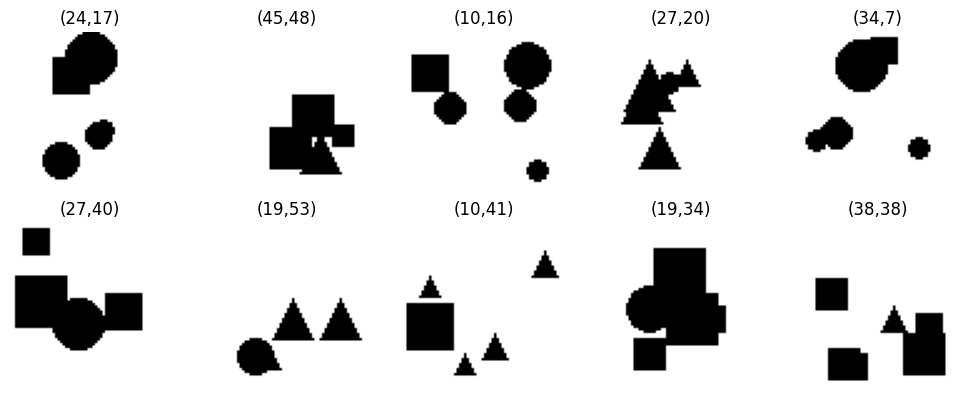

In [17]:
# ============================================================
# 0. Imports & device
# ============================================================
import torch, random, math, numpy as np
from torch import nn
from torch.utils.data import Dataset, DataLoader
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# ============================================================
# 1. Online dataset: 64×64, target = (cx,cy) ∈ [0,63]²  (float32)
# ============================================================
IMAGE = 64
SHAPES = ("circle", "square", "triangle")

def draw_shape(drawer, shape_type, center_x, center_y, radius):
    if shape_type == "circle":
        drawer.ellipse([center_x - radius, center_y - radius,
                        center_x + radius, center_y + radius], fill="black")
    elif shape_type == "square":
        drawer.rectangle([center_x - radius, center_y - radius,
                          center_x + radius, center_y + radius], fill="black")
    else:  # triangle
        drawer.polygon([
            (center_x, center_y - radius),
            (center_x - radius, center_y + radius),
            (center_x + radius, center_y + radius)
        ], fill="black")

class OddXYDataset(Dataset):
    """
    Generates images on-the-fly:
      * several random shapes of the same type
      * 1 additional shape of a different type
    Returns:
      * image (1×64×64 tensor, float32 normalized to [0,1])
      * label: float tensor [cx, cy] with center of the odd shape
    Arguments:
        num_samples             – total number of samples in the dataset
        same_shape_count_range – tuple (min, max), number of identical shapes
        shape_radius_range      – tuple (min_radius, max_radius) for shape size
    """
    def __init__(self,
                 num_samples,
                 same_shape_count_range=(3, 6),
                 shape_radius_range=(4, 10)):
        self.num_samples = num_samples
        self.same_shape_count_range = same_shape_count_range
        self.radius_min, self.radius_max = shape_radius_range

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        base_shape = random.choice(SHAPES)
        odd_shape = random.choice([s for s in SHAPES if s != base_shape])

        img = Image.new("L", (IMAGE, IMAGE), "white")
        drawer = ImageDraw.Draw(img)

        # draw identical shapes
        for _ in range(random.randint(*self.same_shape_count_range)):
            radius = random.randint(self.radius_min, self.radius_max)
            cx = random.randint(radius, IMAGE - radius - 1)
            cy = random.randint(radius, IMAGE - radius - 1)
            draw_shape(drawer, base_shape, cx, cy, radius)

        # draw the odd shape (with known center)
        radius = random.randint(self.radius_min, self.radius_max)
        cx = random.randint(radius, IMAGE - radius - 1)
        cy = random.randint(radius, IMAGE - radius - 1)
        draw_shape(drawer, odd_shape, cx, cy, radius)

        img_tensor = torch.tensor(np.array(img), dtype=torch.float32).unsqueeze(0) / 255.
        label_tensor = torch.tensor([float(cx), float(cy)], dtype=torch.float32)
        return img_tensor, label_tensor

def show_examples(num_examples=10):
    """
    Displays a grid of image samples from OddXYDataset using a DataLoader with batch_size=1.

    Args:
        num_examples (int): Number of examples to display.
    """
    dataset = OddXYDataset(num_samples=num_examples)
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

    num_columns = 5
    num_rows = math.ceil(num_examples / num_columns)

    fig, axes = plt.subplots(num_rows, num_columns, figsize=(num_columns * 2, num_rows * 2))

    for i, (image, label) in enumerate(dataloader):
        if i >= num_examples:
            break
        image_np = image.squeeze(0).squeeze(0).numpy()  # B=1,C=1,H,W --> H,W
        cx, cy = label.squeeze(0)                       # B=1,2       --> 2
        axes.flat[i].imshow(image_np, cmap="gray")
        axes.flat[i].set_title(f"({cx:.0f},{cy:.0f})")
        axes.flat[i].axis("off")

    for j in range(i + 1, num_rows * num_columns):
        axes.flat[j].axis("off")

    plt.tight_layout()
    plt.show()



show_examples()